# Project: **Global Earthquake-Tsunami**

**Author:** Gorka Dabó

## 0. Introduction

In this study, we analyze a historical earthquake dataset to identify their magnitude and the factors linked to tsunami generation. With this, we will evaluate whether the available information allows us to anticipate both the occurrence of tsunamis (classification) and the magnitude of the event (regression). The study is structured around five research questions and combines exploratory analysis with classical statistical approaches and machine learning, including supervised models and unsupervised techniques to detect patterns.

The objective is twofold: to provide evidence-based answers to the research questions and to verify the real predictive capacity of the dataset, assessing to what extent the variables are useful for prediction and what limitations they present.

## Research Questions
1. What characteristics differentiate earthquakes that produce tsunamis from those that do not?
2. Are the strength or shallowness of earthquakes related to tsunami generation?
3. Are there natural patterns or distinct groups of earthquakes based on their seismic and geographic characteristics?
4. To what extent do seismic characteristics allow for the prediction of earthquake magnitude?
5. Is it possible to predict whether an earthquake will generate a tsunami based on its seismic and geographic characteristics?



---


## 1. Data loading, libraries, and utilities

### Importing necessary libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Statistics and tests
from scipy import stats
from scipy.stats import randint, uniform, gaussian_kde
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# ML / Preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, confusion_matrix, roc_curve, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, mean_absolute_error, roc_curve, auc
)
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression

# XGBoost
from xgboost import XGBClassifier

# Maps
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point

# Visualization
import seaborn as sns

# For maps
from matplotlib.colors import Normalize

# Others
from statsmodels.stats.multitest import multipletests
from itertools import product

### Ensuring reproducibility through seed

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print('Environment loaded correctly.')

Environment loaded correctly.


### Data loading

In [3]:
# Place the CSV in ./data/ at the same level as this notebook:
#    - earthquake_data_tsunami.csv

# Charts: clean style
plt.rcParams["figure.figsize"] = (8,5)

# Load data
file_path = "./data/earthquake_data_tsunami.csv"
df = pd.read_csv(file_path)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Original copy for null analysis and EDA
df_orig = df.copy()

print(df_orig.shape) # 782 samples, 13 variables
df_orig.head()

(782, 13)


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


### Variables

| Variable      | Type                | Units / Range               | Description                                                        |
|--------------|---------------------|-----------------------------|--------------------------------------------------------------------|
| `magnitude`  | Float               | Richter Scale               | Energy released by the earthquake. **Target** for regression.      |
| `cdi`        | Integer             | 0–9                         | Community Decimal Intensity (perceived intensity by the population).|
| `mmi`        | Integer             | 1–9                         | Observed damage intensity (Modified Mercalli Scale).               |
| `sig`        | Integer             | ~650–2910                   | Global significance/impact score of the event.                     |
| `nst`        | Integer             | 0–934                       | Number of seismic stations that recorded the event.                |
| `dmin`       | Float               | Geographic degrees          | Angular distance to the nearest station.                           |
| `gap`        | Float               | Degrees                     | Azimuthal gap (azimuthal coverage of stations).                    |
| `depth`      | Float               | Kilometers                  | Hypocenter depth (how deep the earthquake occurs).                 |
| `latitude`   | Float               | Degrees                     | Latitude of the epicenter (WGS84).                                 |
| `longitude`  | Float               | Degrees                     | Longitude of the epicenter (WGS84).                                |
| `Year`       | Integer             | 2001–2022                   | Year of the event.                                                 |
| `Month`      | Integer             | 1–12                        | Month of the event.                                                |
| `tsunami`    | Binary (0/1)        | —                           | Indicator of whether a tsunami was generated. **Target** for classification. |

## 2. EDA — Exploratory Data Analysis

### 2.1 Checking for nulls and duplicates

In [4]:
# Percentage of nulls
nulls = df_orig.isna().mean().mul(100).round(2)
display(nulls.to_frame(name="null_pct(%)"))

,null_pct(%)
magnitude,0.0
cdi,0.0
mmi,0.0
sig,0.0
nst,0.0
dmin,0.0
gap,0.0
depth,0.0
latitude,0.0
longitude,0.0


We observe that no variable has null values.

In [5]:
# --- Percentage of duplicate rows (all columns) ---
# Mark all occurrences of repeated rows as duplicates (not just the 2nd one onwards)
dup_mask_all = df_orig.duplicated(keep=False)

pct_dup_rows = dup_mask_all.mean() * 100
num_dup_rows = dup_mask_all.sum()

print(f"Duplicate rows (all copies): {num_dup_rows} out of {len(df_orig)} "
      f"→ {pct_dup_rows:.2f}%")

Duplicate rows (all copies): 0 out of 782 → 0.00%


We observe that there are no duplicate rows.

### Statistical summary

In [6]:
# Full statistical summary
from IPython.display import display

desc_all = df_orig.describe(include='all').T
display(desc_all)

,count,mean,std,min,25%,50%,75%,max
magnitude,782.0,6.941125,0.445514,6.5000,6.60000,6.8000,7.1000,9.1000
cdi,782.0,4.333760,3.169939,0.0000,0.00000,5.0000,7.0000,9.0000
mmi,782.0,5.964194,1.462724,1.0000,5.00000,6.0000,7.0000,9.0000
sig,782.0,870.108696,322.465367,650.0000,691.00000,754.0000,909.7500,2910.0000
nst,782.0,230.250639,250.188177,0.0000,0.00000,140.0000,445.0000,934.0000
dmin,782.0,1.325757,2.218805,0.0000,0.00000,0.0000,1.8630,17.6540
gap,782.0,25.038990,24.225067,0.0000,14.62500,20.0000,30.0000,239.0000
depth,782.0,75.883199,137.277078,2.7000,14.00000,26.2950,49.7500,670.8100
latitude,782.0,3.538100,27.303429,-61.8484,-14.59560,-2.5725,24.6545,71.6312
longitude,782.0,52.609199,117.898886,-179.9680,-71.66805,109.4260,148.9410,179.6620


### 2.2 Distributions — Density histograms of all variables

In this section, the individual distributions of the numerical variables from the original dataset are analyzed using density histograms.

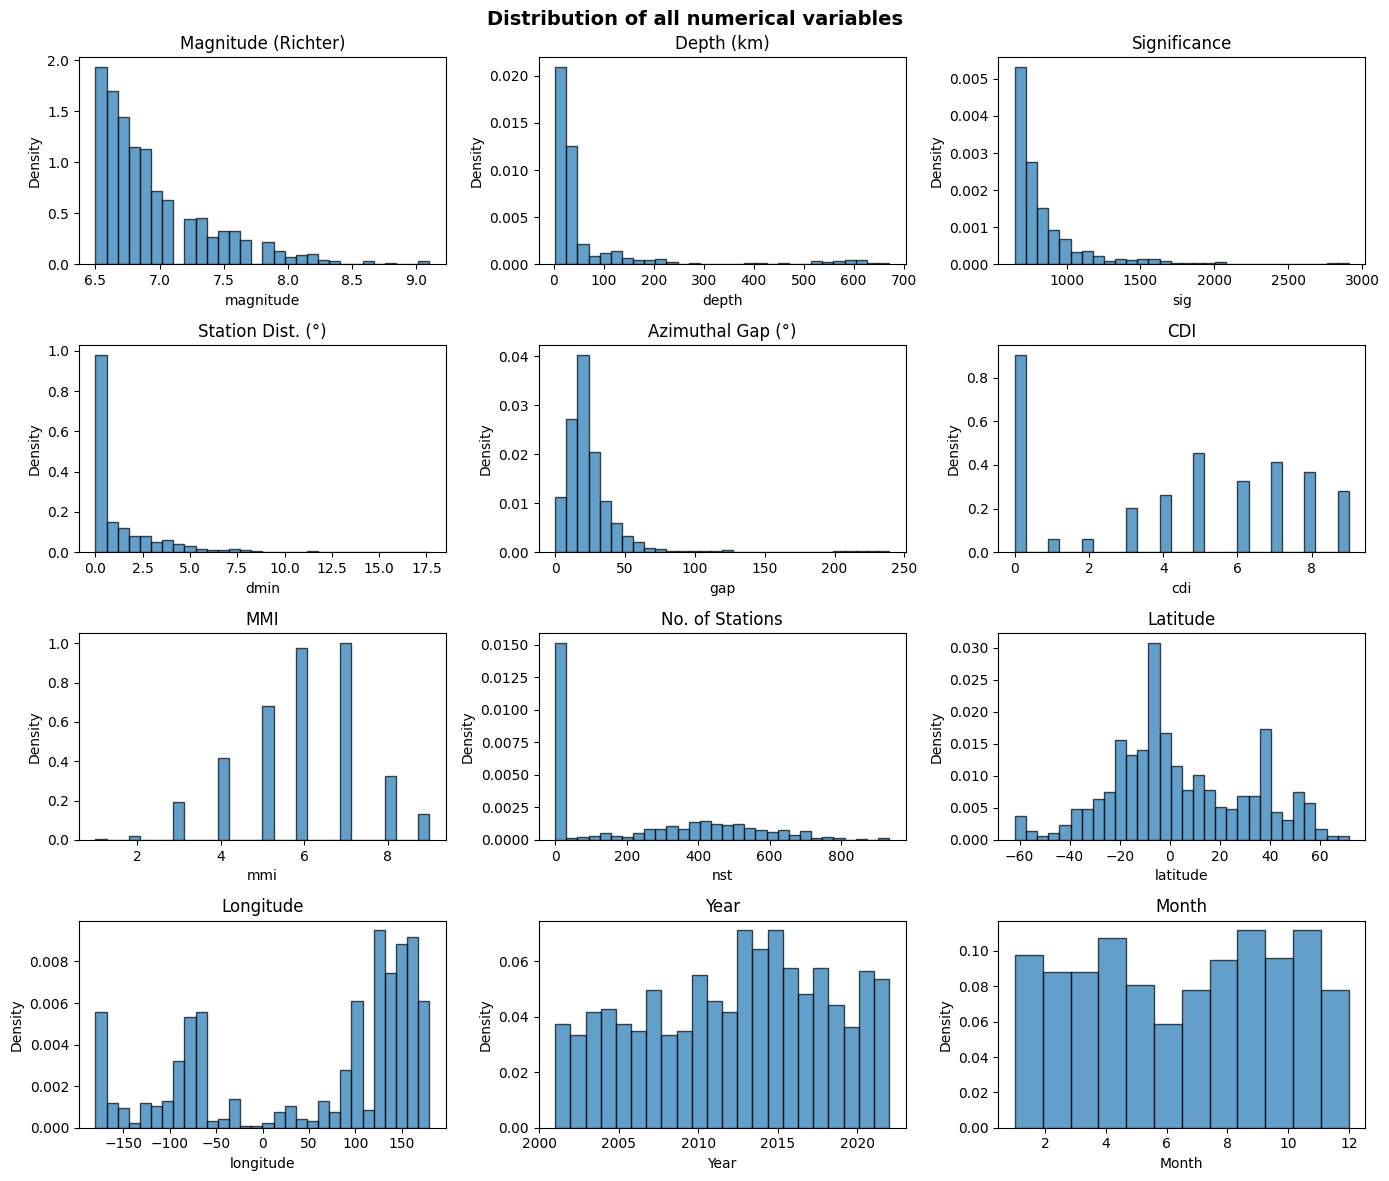

In [7]:
# Variables to plot and their configurations
vars_config = [
    ("magnitude", "Magnitude (Richter)", 30),
    ("depth", "Depth (km)", 30),
    ("sig", "Significance", 30),
    ("dmin", "Station Dist. (°)", 30),
    ("gap", "Azimuthal Gap (°)", 30),
    ("cdi", "CDI", 30),
    ("mmi", "MMI", 30),
    ("nst", "No. of Stations", 30),
    ("latitude", "Latitude", 30),
    ("longitude", "Longitude", 30),
    ("Year", "Year", 22),
    ("Month", "Month", 12),
]

fig, axes = plt.subplots(4, 3, figsize=(14, 12))
axes = axes.flatten()

for ax, (col, label, bins) in zip(axes, vars_config):
    if col in df_orig.columns:
        data = df_orig[col].dropna().values
        ax.hist(data, bins=bins, density=True, edgecolor='black', alpha=0.7)
        ax.set_title(label)
        ax.set_xlabel(col)
        ax.set_ylabel("Density")

plt.suptitle("Distribution of all numerical variables", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

The **magnitude** distribution is clearly right-skewed (long tail). Most earthquakes are concentrated between 6.5 and 7.2, with few extreme events >8.5. This indicates that the strongest quakes are rare but influential in correlations with `sig` and `tsunami`.

The **depth** distribution is highly asymmetrical; most events occur at shallow depths (<50 km), and few exceed 600 km. Tsunamis tend to originate from shallow events, which will be relevant in subsequent analyses.

The **sig** distribution is also positively skewed. The `sig` variable (seismic significance) combines magnitude, depth, and other factors, which is why its distribution is similar to that of `magnitude`.

The **dmin** distribution is extremely concentrated at low values (<2). It represents the minimum distance to the seismic station, explaining the accumulation near zero. The long tail may reflect measurements from remote areas or very distant stations.

The **gap** distribution measures the angular coverage of the stations that detected the event. Most values are grouped between 0 and 40, with a tail toward 200. High gaps indicate lower precision in the event's location.

The intensity reported by the community (**cdi**) is low in most cases (many zeros), although some events reach high values (7–9).

The perceived intensity (**mmi**) is concentrated between values 5 and 7, indicating that most earthquakes were moderately strong.

Most earthquakes were detected by very few stations (**nst**), but some large events had hundreds of records.

The **latitude** shows a wide distribution with concentrations near the equator (0°) and secondary peaks toward ±40°, consistent with the location of global seismic zones.

Regarding **longitude**, three major concentrations are observed (~−100°, 120–160°, and 150°), corresponding to seismic regions of the Pacific and the Ring of Fire.

Records are continuous since 2000, with a higher frequency of events reported between 2012–2016 in the **Year** distribution, likely due to improvements in detection.

The **Month** frequency is fairly uniform, with no clear seasonality in the occurrence of earthquakes.

**Note on temporal variables:** The variables `Year` and `Month` will not be used in the regression or classification models. Their relevance is primarily descriptive, helping to understand the historical distribution of the data. However, the occurrence of earthquakes and tsunamis depends on physical and geological factors rather than a specific point in the calendar. Including them could introduce noise or lead the models to capture spurious correlations that do not generalize to future events.

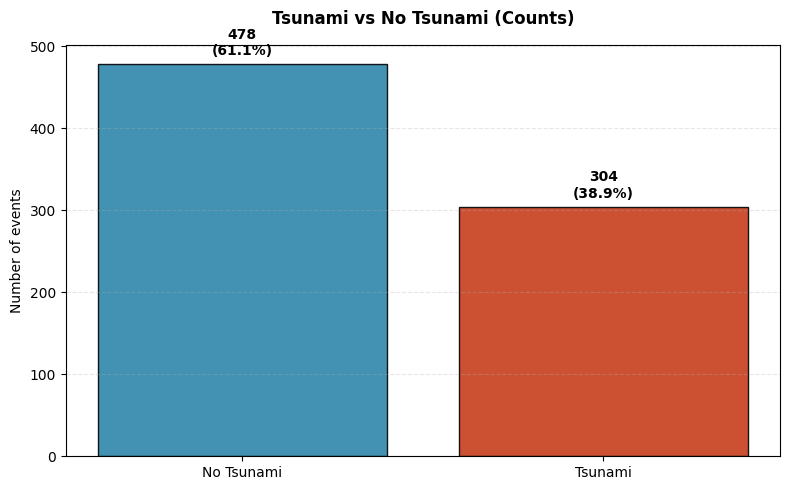

In [8]:
# Ensure binary data
y = df_orig["tsunami"].dropna().astype(int)

# Sorted counts
counts = y.value_counts().sort_index()
labels = ["No Tsunami", "Tsunami"]
values = [counts.get(0, 0), counts.get(1, 0)]
total = sum(values)
pct = [v * 100.0 / total if total > 0 else 0 for v in values]

# Consistent colors
colors = ["#2E86AB", "#C73E1D"]

# --- Bar chart ---
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=colors, edgecolor="black", alpha=0.9)
plt.title("Tsunami vs No Tsunami (Counts)", fontweight="bold", pad=15)
plt.ylabel("Number of events")
plt.grid(axis="y", linestyle="--", alpha=0.3)

# Labels with count and percentage
for b, v, p in zip(bars, values, pct):
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 8,
             f"{v}\n({p:.1f}%)",
             ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

Although the dataset presents a relevant number of tsunami events (38.9%), the positive class remains smaller than the negative one (61.1%), meaning the dataset is slightly imbalanced.
Later, in the classification section, we will stratify the training and testing split to maintain the original class proportion and avoid bias in the model.

NOTE: Upon observing the histograms of the main numerical variables, skewed distributions with long tails and potential outliers are evident (especially in `depth`, `sig`, and `gap`).
Therefore, in the next section, a formal outlier analysis using the Interquartile Range (IQR) method will be applied to quantify and clean these cases.

In the following graph, we compare the magnitude distribution between events with and without a tsunami to see if the `magnitude` variable alone provides separation power; that is, to analyze whether earthquakes that generated tsunamis tend to show higher average magnitudes or a different distribution compared to those that did not.

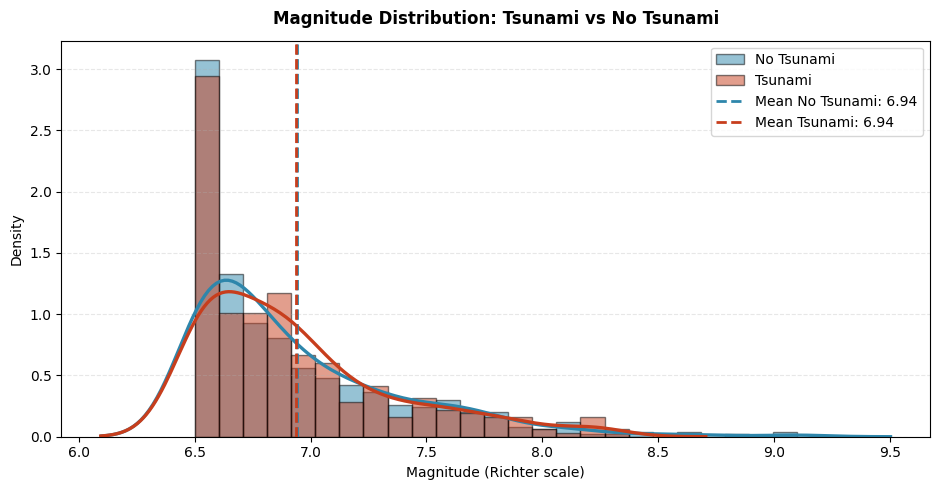

In [9]:
# Use df if it exists, otherwise use df_orig
_df = df if "df" in globals() else df_orig

# Series by class
mag_no = _df.loc[_df["tsunami"] == 0, "magnitude"].dropna()
mag_si = _df.loc[_df["tsunami"] == 1, "magnitude"].dropna()

# Consistent colors
c_no, c_si = "#2E86AB", "#C73E1D"

# Same bin grid for both distributions
all_mags = pd.concat([mag_no, mag_si], ignore_index=True)
bins = np.histogram_bin_edges(all_mags, bins=25)

fig, ax = plt.subplots(figsize=(9.5, 5))

# Bars (density) in the background
ax.hist(mag_no, bins=bins, density=True, alpha=0.50, color=c_no, edgecolor="black", label="No Tsunami")
ax.hist(mag_si, bins=bins, density=True, alpha=0.50, color=c_si, edgecolor="black", label="Tsunami")

# KDE "waves" in the foreground
sns.kdeplot(mag_no, ax=ax, color=c_no, linewidth=2.4)
sns.kdeplot(mag_si, ax=ax, color=c_si, linewidth=2.4)

# Mean line for each group
ax.axvline(mag_no.mean(), color=c_no, linestyle="--", linewidth=2, label=f"Mean No Tsunami: {mag_no.mean():.2f}")
ax.axvline(mag_si.mean(), color=c_si, linestyle="--", linewidth=2, label=f"Mean Tsunami: {mag_si.mean():.2f}")

# Aesthetics
ax.set_title("Magnitude Distribution: Tsunami vs No Tsunami", fontweight="bold", pad=12)
ax.set_xlabel("Magnitude (Richter scale)")
ax.set_ylabel("Density")
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

The graph shows the magnitude distribution of earthquakes that did generate tsunamis (in red) and those that did not (in blue). The dashed vertical lines mark the average magnitude for each group, which in this case is practically identical (~6.94). This indicates that, while earthquakes producing tsunamis tend to show slightly higher variability in magnitude, there is no significant difference between the two groups in terms of their mean value.

In summary, the graph suggests that magnitude alone does not clearly explain the occurrence of a tsunami, and that it will be necessary to analyze other variables (such as depth or location) to better understand the determining factors. This is why, later on, we will perform various tests to determine which characteristics differentiate earthquakes that produce tsunamis from those that do not.

### 2.3 Boxplots by Group (`tsunami`)

In this section, we analyze the differences in the distribution of various variables between earthquakes that generated tsunamis and those that did not.

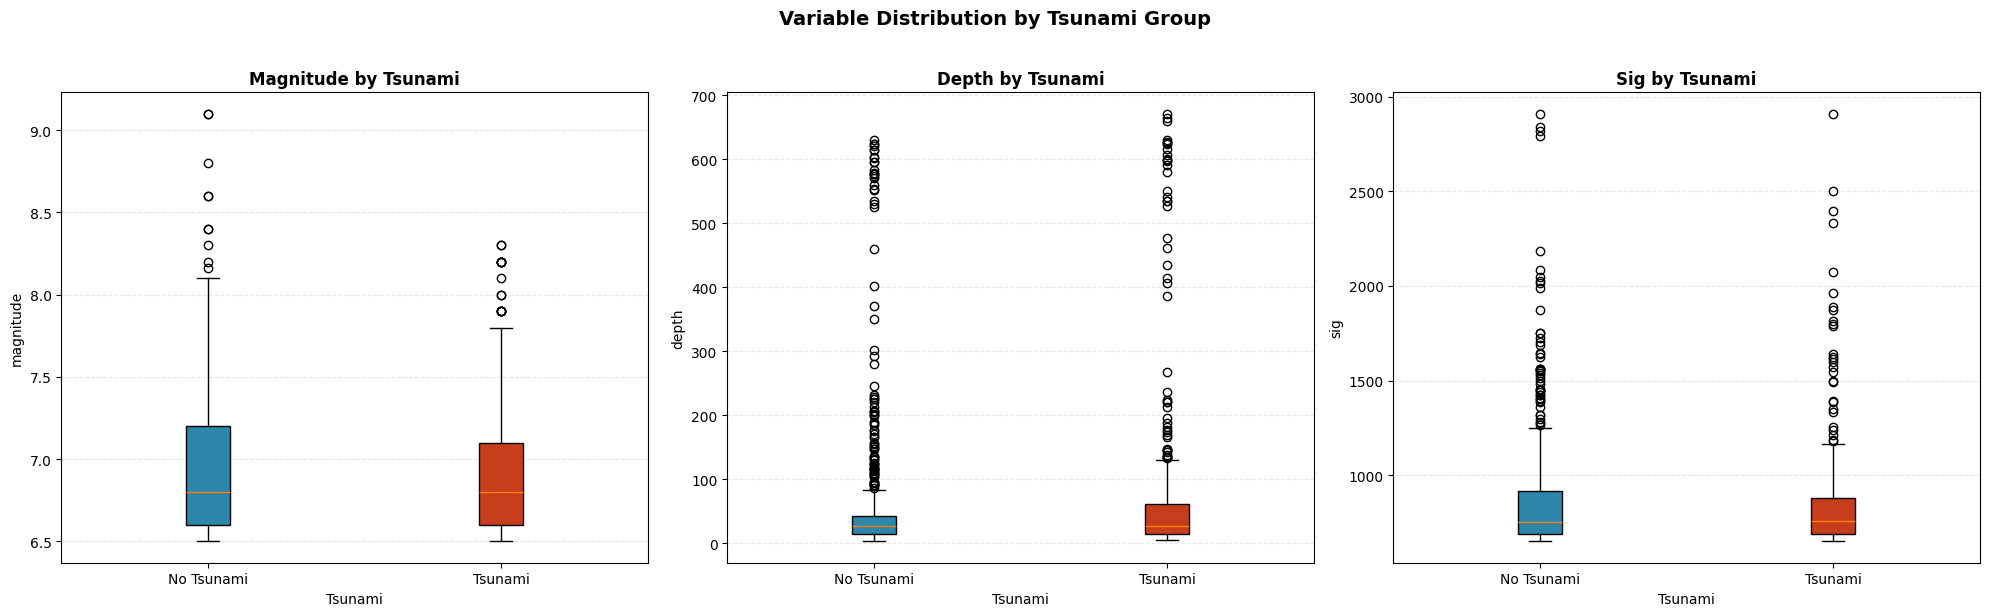

In [10]:
# Variables to analyze
variables = ["magnitude", "depth", "sig"]
titles = ["Magnitude", "Depth", "Sig"]

# Create figure with 3 subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, var, title in zip(axes, variables, titles):
    vals0 = df_orig[df_orig["tsunami"] == 0][var].dropna().values
    vals1 = df_orig[df_orig["tsunami"] == 1][var].dropna().values
    
    bp = ax.boxplot([vals0, vals1], tick_labels=["No Tsunami", "Tsunami"], patch_artist=True)
    
    # Colors to differentiate groups
    bp['boxes'][0].set_facecolor('#2E86AB')
    bp['boxes'][1].set_facecolor('#C73E1D')
    
    ax.set_title(f"{title} by Tsunami", fontweight="bold")
    ax.set_xlabel("Tsunami")
    ax.set_ylabel(var)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.suptitle("Variable Distribution by Tsunami Group", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

**Magnitude:** Magnitudes are very similar between earthquakes with and without tsunamis, with nearly identical medians and significant overlap. No clear differences are observed between the two groups.

**Depth:** The depth distribution is very similar between both groups. The medians and ranges are almost the same, so there is no apparent clear difference between earthquakes with and without tsunamis.

**Sig:** The distributions for the `sig` variable are very similar between both groups. No clear differences are observed between earthquakes that generated tsunamis and those that did not.

These results suggest that, later on, we will need to analyze which specific features influence the occurrence of a tsunami when an earthquake occurs.

### 2.4 Geographic and temporal analysis

#### Geographic analysis

In this section, the spatial and temporal distribution of the earthquakes recorded in the dataset is studied.

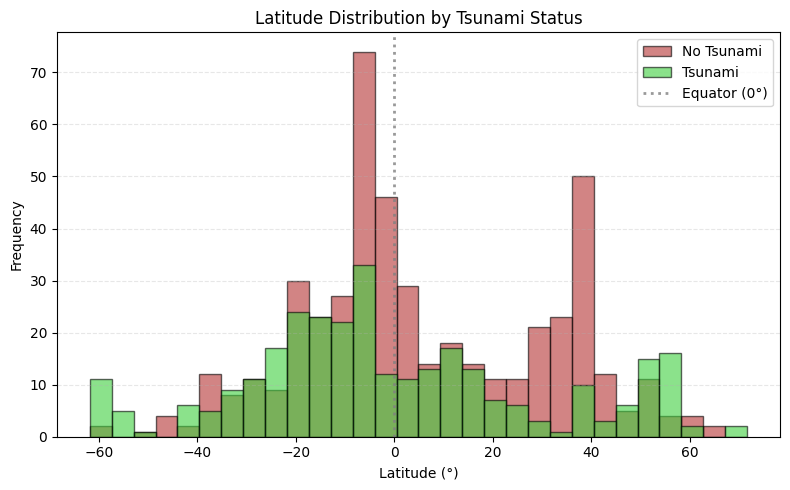

In [11]:
# Series by class (in case there are NaNs in 'tsunami', we treat them as 0 = no tsunami)
t = df_orig["tsunami"].fillna(0).astype(int)
lat_no = df_orig.loc[t == 0, "latitude"].dropna()
lat_si = df_orig.loc[t == 1, "latitude"].dropna()

# Same bin grid to properly compare both distributions
all_latitudes = pd.concat([lat_no, lat_si], ignore_index=True)
bins = np.histogram_bin_edges(all_latitudes, bins=30)

# Consistent colors
c_no, c_si = "#B53333", "#3ECF3E"

plt.figure(figsize=(8, 5))
# Overlapping bars (frequency)
plt.hist(lat_no, bins=bins, alpha=0.60, color=c_no, edgecolor="black", label="No Tsunami")
plt.hist(lat_si, bins=bins, alpha=0.60, color=c_si, edgecolor="black", label="Tsunami")

# Equator line
plt.axvline(0, color="gray", linestyle=":", linewidth=2, alpha=0.8, label="Equator (0°)")

# Aesthetics and axes
plt.title("Latitude Distribution by Tsunami Status")
plt.xlabel("Latitude (°)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3, linestyle="--", axis="y")
plt.legend()
plt.tight_layout()
plt.show()

It is observed that both types of events are mainly concentrated near the equator (gray dashed line), a region characterized by high tectonic activity.

Next, the geographic location of the earthquakes is represented, differentiating between events that generated tsunamis and those that did not.

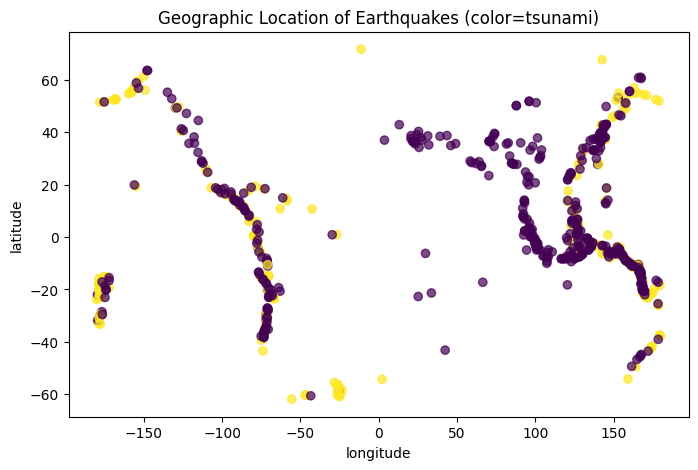

In [12]:
# Geographic map
if {"latitude", "longitude"}.issubset(df_orig.columns):
    plt.figure()
    m = df_orig["tsunami"].fillna(0) if "tsunami" in df_orig.columns else 0
    plt.scatter(df_orig["longitude"], df_orig["latitude"], c=m, alpha=0.7)
    plt.title("Geographic Location of Earthquakes (color=tsunami)")
    plt.xlabel("longitude"); plt.ylabel("latitude")
    plt.show()

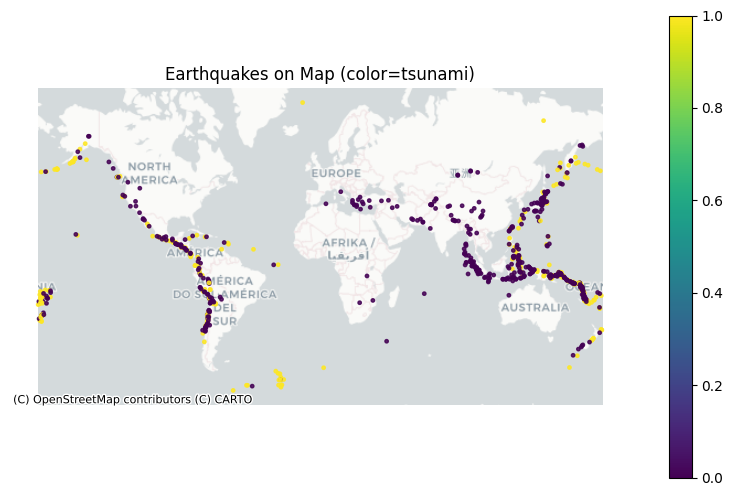

In [13]:
# Create a copy and ensure no NaNs in location and target
df = df_orig.dropna(subset=["latitude", "longitude"]).copy()
df["tsunami"] = df.get("tsunami", 0).fillna(0)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])], crs="EPSG:4326")
gdf = gdf.to_crs(3857)  # Web Mercator (required for the basemap)

# Plotting
ax = gdf.plot(column="tsunami", markersize=6, alpha=0.85, legend=True, figsize=(10,6))
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)  # Background map

# Aesthetics
ax.set_axis_off()
ax.set_title("Earthquakes on Map (color=tsunami)")
plt.show()

The figure shows the geographic distribution of the recorded earthquakes, using color to differentiate between those that generated tsunamis (in yellow) and those that did not (in purple).

A clear concentration of events is observed along the main tectonic plate boundaries, especially in the Pacific Ring of Fire, where the majority of tsunamis are also located.

This confirms that the most intense seismic activity and events with tsunami potential are concentrated in oceanic subduction regions, which is consistent with global tectonic dynamics.

At this point, after visually analyzing the geographic distribution of earthquakes and the potential concentration of tsunamis near the equator, we conduct a hypothesis test to determine if this observation has statistical backing. 

The objective of the test is to evaluate whether there are significant differences in the mean latitude between earthquakes that generate tsunamis and those that do not.

In [14]:
# Filter necessary data
df_lat = df_orig[['latitude', 'tsunami']].dropna().copy()

# Separate groups
lat_0 = df_lat.loc[df_lat['tsunami'] == 0, 'latitude']
lat_1 = df_lat.loc[df_lat['tsunami'] == 1, 'latitude']

# --- Normality Test (Shapiro–Wilk) ---
shapiro_0 = stats.shapiro(lat_0)
shapiro_1 = stats.shapiro(lat_1)

print(f"Shapiro tsunami=0: W={shapiro_0.statistic:.3f}, p-value={shapiro_0.pvalue:.3g}")
print(f"Shapiro tsunami=1: W={shapiro_1.statistic:.3f}, p-value={shapiro_1.pvalue:.3g}")

Shapiro tsunami=0: W=0.967, p-value=6.15e-09
Shapiro tsunami=1: W=0.960, p-value=2.23e-07


The results of the Shapiro–Wilk test show p-values lower than 0.05 for both groups (tsunami=0 and tsunami=1), indicating that the data do not follow a normal distribution.

For this reason, the non-parametric Mann–Whitney U test is used, as it does not assume normality and allows for the comparison of the medians of both groups to detect significant differences in latitude.

In [15]:
# --- Non-parametric Mann–Whitney U Test ---
u_stat, p_val = stats.mannwhitneyu(lat_0, lat_1, alternative='two-sided')
print(f"Mann-Whitney U = {u_stat:.2f}, p-value = {p_val:.3g}")

# --- Effect Size Calculation (Cliff’s δ) ---
def cliffs_delta(a, b):
    gt = sum(x > y for x in a for y in b)
    lt = sum(x < y for x in a for y in b)
    return (gt - lt) / (len(a) * len(b))

delta = cliffs_delta(lat_0, lat_1)
print(f"Cliff’s δ = {delta:.3f}")

Mann-Whitney U = 83527.00, p-value = 0.000415
Cliff’s δ = 0.150


The Mann–Whitney U test shows a p-value ≈ 0.0004, indicating that there are statistically significant differences in latitude between earthquakes that generate tsunamis and those that do not.

The effect size (Cliff’s δ = 0.15) reveals that the difference is small; that is, although significant, it is not of great magnitude.

To visualize this difference between groups, the results will be represented using boxplots, which allow for the observation of the median, dispersion, and potential outliers.

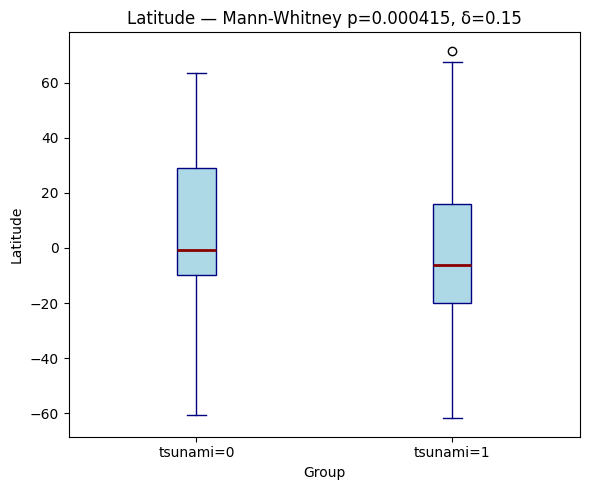

In [16]:
# --- Visualization: Boxplot plot ---
plt.figure(figsize=(6,5))
plt.boxplot([lat_0, lat_1],
             tick_labels=['tsunami=0', 'tsunami=1'],
             patch_artist=True,
             boxprops=dict(facecolor='lightblue', color='navy'),
             medianprops=dict(color='darkred', linewidth=2),
             whiskerprops=dict(color='navy'),
             capprops=dict(color='navy'))

plt.xlabel("Group")
plt.ylabel("Latitude")
plt.title(f"Latitude — Mann-Whitney p={p_val:.3g}, δ={delta:.2f}")
plt.tight_layout()
plt.show()

The graph shows that earthquakes associated with tsunamis tend to occur at lower latitudes (closer to the equator) where oceanic subduction zones and higher tectonic activity predominate. This matches the previous maps that showed a higher density of events in that specific region.

After confirming through the Mann–Whitney test that there are significant differences in latitude between earthquakes that generate tsunamis and those that do not, albeit with a small effect size, this section evaluates whether latitude can also act as a predictor of tsunami occurrence. To do this, a ROC curve is constructed to quantify the discriminative ability of latitude to distinguish between both types of events.

The objective is to determine if there is a pattern in latitude with predictive value that complements the differences observed statistically.

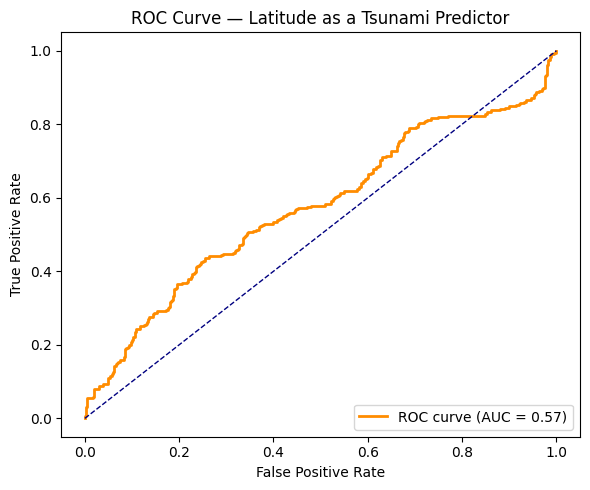

In [17]:
# --- ROC Curve (using latitude to predict tsunami) ---
y_true = df_lat['tsunami']
y_score = df_lat['latitude']  # the continuous variable

# We use -y_score because tsunamis tend to occur at lower (more negative/equatorial) latitudes
fpr, tpr, _ = roc_curve(y_true, -y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Latitude as a Tsunami Predictor')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

The resulting ROC curve shows an AUC of 0.57, indicating a modest predictive capacity of latitude for determining whether an earthquake will generate a tsunami.

The area under the curve value is slightly above 0.5, suggesting that latitude, on its own, discriminates only marginally better than chance between the two types of events.

Therefore, it is concluded that this geographic parameter is not sufficient as a predictor, and it is necessary to consider other variables such as magnitude, depth, or fault mechanism.

**Brief note:** We use `-y_score` because the effect sign (Cliff’s δ > 0) showed that positive cases (tsunamis) tended toward lower latitude values; inverting the score aligns "higher score → higher probability of tsunami" for the ROC calculation.

#### Temporal analysis

In this section, the temporal evolution of the recorded earthquakes over the years is analyzed, with the goal of identifying potential trends or fluctuations in their frequency.

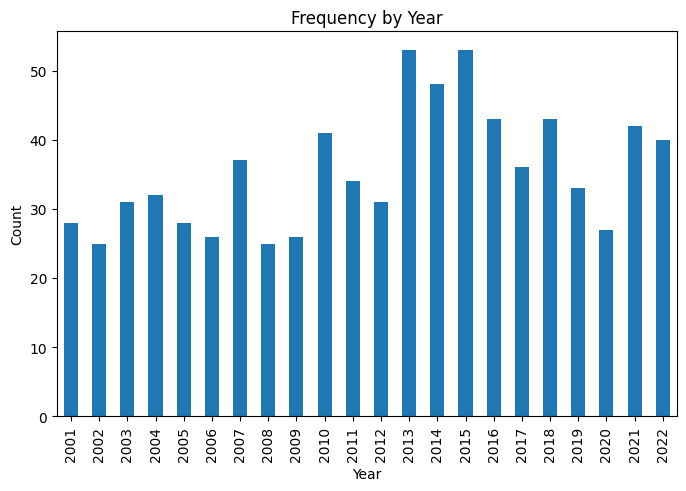

In [18]:
# Frequency by year and month
if "Year" in df_orig.columns:
    plt.figure()
    df_orig["Year"].value_counts().sort_index().plot(kind="bar")
    plt.title("Frequency by Year")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.show()

The graph shows the annual frequency of earthquakes recorded between 2001 and 2022. Some interannual variability is observed, with notable peaks around 2013 and 2015, years in which seismic activity was particularly high. No clear sustained upward or downward trend is apparent, suggesting that the frequency of earthquakes remains relatively stable throughout the analyzed period.

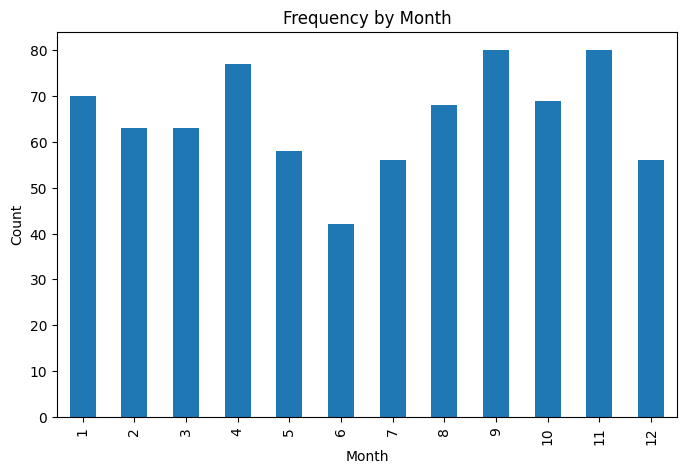

In [19]:
# Frequency by month
if "Month" in df_orig.columns:
    plt.figure()
    df_orig["Month"].value_counts().sort_index().plot(kind="bar")
    plt.title("Frequency by Month")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.show()

The graph represents the frequency of earthquakes by month. No marked seasonality is observed, although the months of April, September, and November show a higher concentration of events. This indicates that the occurrence of earthquakes does not significantly depend on the time of year, which is consistent with their tectonic origin, independent of climatic factors.

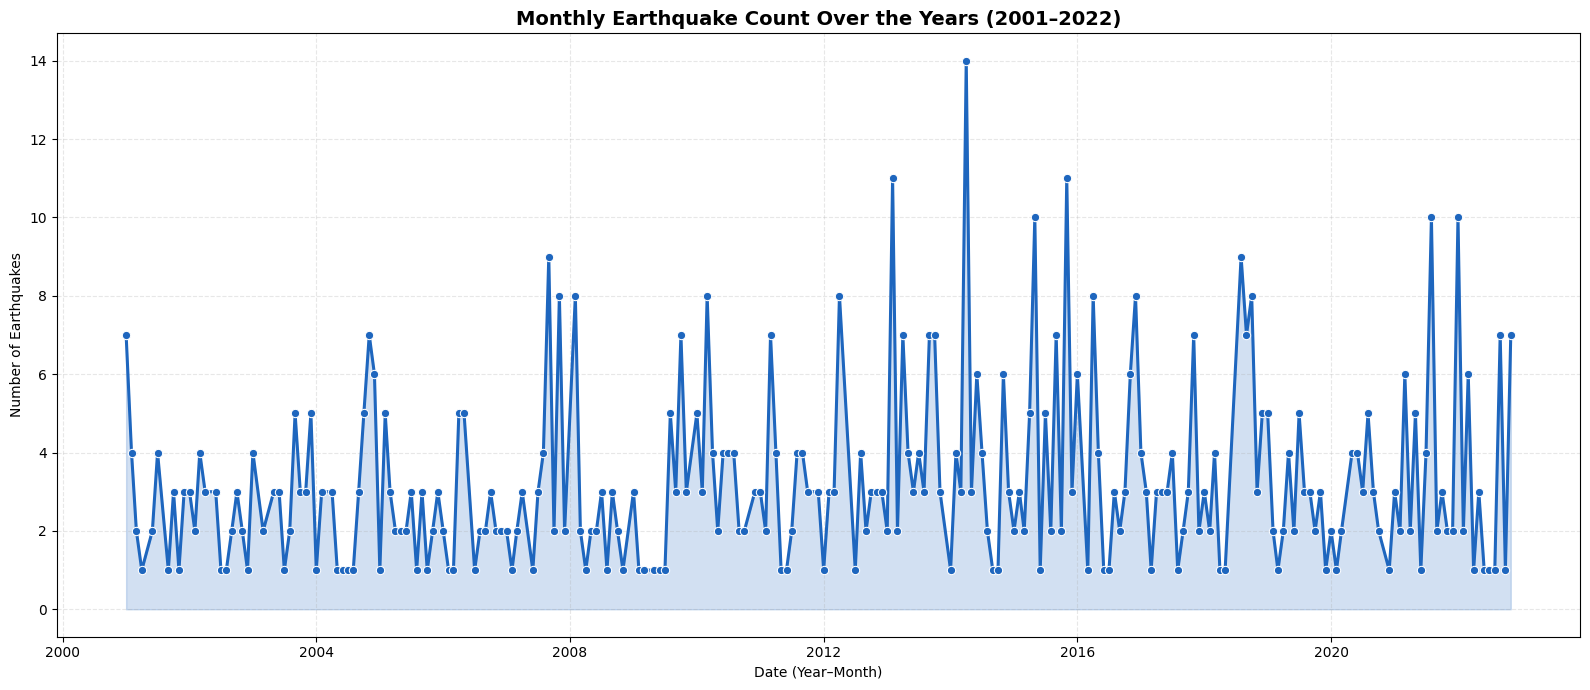

In [20]:
# Group by Year and Month and count events
year_month_counts = (
    df.groupby(['Year', 'Month'])
    .size()
    .reset_index(name='count')
)

# Create a date-type column (first day of the month)
year_month_counts['date'] = pd.to_datetime(
    year_month_counts.assign(DAY=1)[['Year', 'Month', 'DAY']]
)

# Sort by date
year_month_counts = year_month_counts.sort_values('date')

# --- Plot ---
plt.figure(figsize=(16, 7))
sns.lineplot(
    data=year_month_counts,
    x='date',
    y='count',
    marker='o',
    linewidth=2.2,
    color="#1E66BE"
)
plt.fill_between(year_month_counts['date'],
                 year_month_counts['count'],
                 color='#1E66BE',
                 alpha=0.2)

plt.title('Monthly Earthquake Count Over the Years (2001–2022)',
          fontsize=14, fontweight='bold')
plt.xlabel('Date (Year–Month)')
plt.ylabel('Number of Earthquakes')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

The graph shows the monthly evolution of the number of earthquakes between 2001 and 2022, revealing notable fluctuations over time without a clear trend, although with seismic activity peaks in specific years.

After observing the temporal evolution of earthquakes, which shows notable fluctuations but no evident trend, it is consistent for us to analyze whether there is any statistically significant relationship between the passage of time and the occurrence of tsunamis.

In [21]:
# --- Spearman Correlation: Year vs Tsunami occurrence ---
df_tmp = df_orig[['Year', 'tsunami']].dropna().copy()
rho, p = stats.spearmanr(df_tmp['Year'], df_tmp['tsunami'])
print(f"Spearman Year↔tsunami: rho={rho:.3f}, p={p:.3g}, n={len(df_tmp)}")

# --- Is Year associated with sensor coverage? ---
df_y = df_orig[['Year', 'dmin', 'nst']].dropna().copy()
rho_dmin, p_dmin = stats.spearmanr(df_y['Year'], df_y['dmin'])
rho_nst, p_nst = stats.spearmanr(df_y['Year'], df_y['nst'])
print(f"Spearman Year↔dmin: rho={rho_dmin:.3f}, p={p_dmin:.3g}")
print(f"Spearman Year↔nst : rho={rho_nst :.3f}, p={p_nst :.3g}\n")

# --- Does Year still "explain" tsunami status when adjusting for coverage? ---
vars_ = ['Year', 'dmin', 'nst']  # optional: add 'gap'
df_log = df_orig[['tsunami'] + vars_].dropna().copy()
X = sm.add_constant(df_log[vars_])
y = df_log['tsunami']
model = sm.Logit(y, X).fit(disp=0)
print(model.summary2().tables[1][['Coef.', 'Std.Err.', 'P>|z|']])

# --- "Cataloging Artifact" vs. "Real Seismic Increase" ---
# Calculating the ratio of tsunamis per year
grp = df_orig.dropna(subset=['Year', 'tsunami']).groupby('Year')['tsunami']
year_ratio = (grp.mean()).reset_index(name='tsunami_ratio')
rho_ratio, p_ratio = stats.spearmanr(year_ratio['Year'], year_ratio['tsunami_ratio'])
print(f"Spearman Year↔tsunami_ratio: rho={rho_ratio:.3f}, p={p_ratio:.3g}, n={len(year_ratio)}")

Spearman Year↔tsunami: rho=0.658, p=2.55e-98, n=782
Spearman Year↔dmin: rho=0.785, p=4.43e-164
Spearman Year↔nst : rho=-0.722, p=9.8e-127

            Coef.   Std.Err.         P>|z|
const -505.139381  63.236506  1.370370e-15
Year     0.250961   0.031376  1.258475e-15
dmin    -0.034325   0.047035  4.655240e-01
nst     -0.003795   0.000721  1.435544e-07
Spearman Year↔tsunami_ratio: rho=0.839, p=1.05e-06, n=22


We can observe that the relationship is positive and strong: as years pass, the probability of an event being cataloged as a tsunami increases. This effect persists even when controlling for the distance to the nearest stations (dmin), the number of sensors recording the event (nst), and the network coverage (gap).

Therefore, we can conclude that more recent cases tend to involve fewer stations and greater distances, which indicates that more events from marine or remote areas are being incorporated into the dataset. This suggests that the temporal trend does not reflect a real change in seismic activity, but rather a progressive improvement in the detection and recording of oceanic events.

### 2.5 Correlation analysis

In this section, the linear correlation between numerical variables is analyzed using a heatmap based on the Pearson coefficient. This analysis allows for the identification of direct or inverse relationships between variables and the detection of potential redundancies or dependencies relevant to subsequent models.

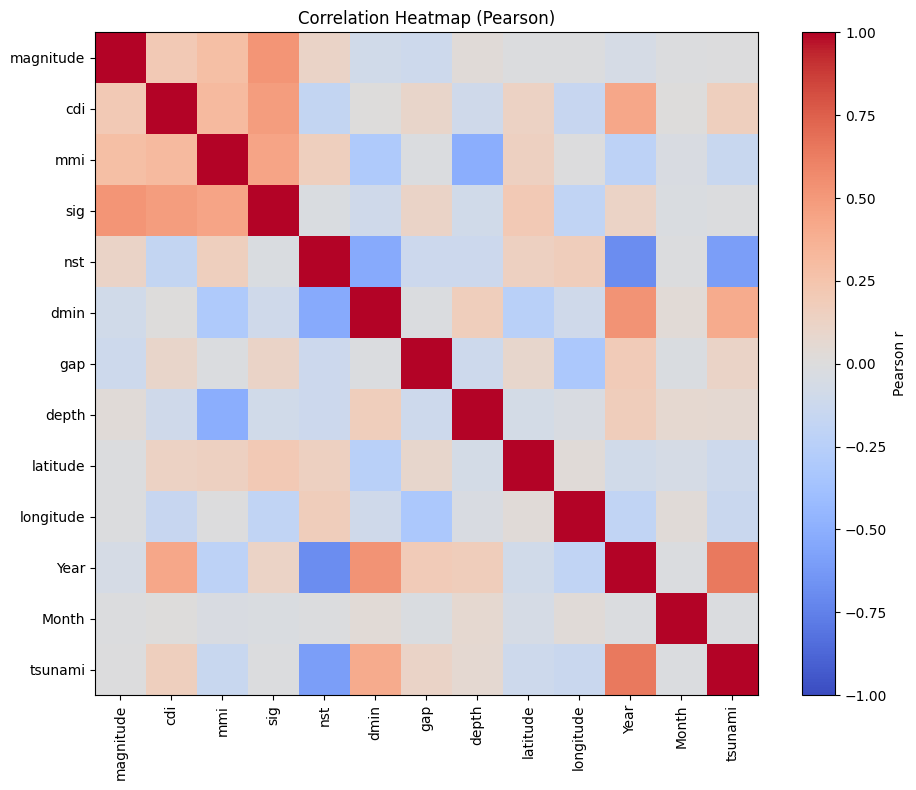

In [22]:
# --- Correlation Heatmap (Pearson) ---
num_df = df_orig.select_dtypes(include=[np.number]).dropna()
corr = num_df.corr()
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (Pearson)")
plt.tight_layout()
plt.show()

The correlation map reveals several noteworthy relationships between the numerical variables. A moderate positive correlation is observed between **magnitude** and the variables **sig** (seismic significance), **mmi** (Modified Mercalli Intensity), and **cdi** (perceived intensity), which is consistent with the fact that stronger earthquakes tend to be more intense and relevant.

There is also a visible correlation between **dmin** (distance to the epicenter) and **gap** (azimuthal gap), which is related to the geometry of the seismic detection network.

On the other hand, the **tsunami** variable does not show strong linear correlations with the rest, indicating that the occurrence of a tsunami does not depend directly on a single variable, but rather on a combination of factors (e.g., magnitude, depth, and geographic location).

Overall, the dataset shows low to moderate correlations, suggesting low multicollinearity, which is favorable for the subsequent predictive models.

Following the visual analysis of the Pearson correlation map, different types of statistical correlations (Pearson and Spearman) are calculated to explore the multicollinearity between variables previously observed.

This step is fundamental before applying regression models, as a high correlation between explanatory variables can distort the model coefficients and reduce their interpretability.

In [23]:
# Select only numerical variables
df_num = df_orig.select_dtypes(include=[np.number]).dropna()

pearson_rows, spearman_rows = [], []
num_cols = df_num.columns

for col in num_cols:
    if col == "magnitude":
        continue
    
    # Pearson Correlation (linear)
    if df_num[col].notna().all():
        r, p = stats.pearsonr(df_num[col], df_num["magnitude"])
    else:
        r, p = np.nan, np.nan
    pearson_rows.append({"variable": col, "pearson_r": r, "p_value": p})
    
    # Spearman Correlation (non-parametric)
    rs, ps = stats.spearmanr(df_num[col], df_num["magnitude"])
    spearman_rows.append({"variable": col, "spearman_rho": rs, "p_value": ps})

# DataFrames sorted by significance
pearson_df = pd.DataFrame(pearson_rows).sort_values("p_value")
spearman_df = pd.DataFrame(spearman_rows).sort_values("p_value")

In [24]:
print("Top 10 correlations with respect to magnitude (Pearson):")
display(pearson_df.head(10))

Top 10 correlations with respect to magnitude (Pearson):


,variable,pearson_r,p_value
2,sig,0.515871,2.162032e-54
1,mmi,0.285552,3.868503e-16
0,cdi,0.209549,3.292193e-09
3,nst,0.113114,1.533475e-03
5,gap,-0.110626,1.947384e-03
4,dmin,-0.091403,1.054974e-02
9,Year,-0.057083,1.107040e-01
6,depth,0.030644,3.921203e-01
8,longitude,-0.013911,6.977156e-01
10,Month,-0.011926,7.391494e-01


In [25]:
print("\nTop 10 correlations with respect to magnitude (Spearman):")
display(spearman_df.head(10))


Top 10 correlations with respect to magnitude (Spearman):


,variable,spearman_rho,p_value
2,sig,0.768550,1.901239e-153
1,mmi,0.259096,1.840872e-13
0,cdi,0.233894,3.537112e-11
5,gap,-0.136592,1.273390e-04
6,depth,0.124018,5.090366e-04
3,nst,0.103130,3.888820e-03
4,dmin,-0.090916,1.097147e-02
9,Year,-0.040186,2.616854e-01
8,longitude,0.024156,4.999804e-01
7,latitude,-0.015134,6.726152e-01


The correlation results indicate a high correlation between **magnitude** and the variable **sig** (seismic significance), with a Spearman value of $\rho \approx 0.77$.

**IMPORTANT**: This extremely high relationship is explained by the dataset description, which states that the **sig** variable is calculated based on several factors that directly include magnitude, instrumental intensity (**mmi**), felt reports (**cdi**), and estimated impact. In other words, **sig** is not an independent measurement but a derived variable that already incorporates information from the value we aim to predict (magnitude). For this reason, using it as a predictor would result in a case of **data leakage**, as the model would be indirectly accessing the target variable during training. To avoid this bias and ensure the validity of the results, the **sig** variable must be excluded from predictive analyses regarding magnitude.

On the other hand, the variables **mmi** (Modified Mercalli Intensity) and **cdi** (perceived intensity) show moderate correlations with magnitude, which is expected since both partially depend on it.

The remaining variables show weak or almost non-existent correlations ($|r| < 0.3$), indicating that there is no significant redundancy among the predictors.

In summary, only the **sig** variable poses a strong collinearity issue, while the others can be used safely in subsequent analyses.

## 3. Hypothesis testing

In this section, various statistical tests are applied to evaluate whether significant differences exist between the groups of interest. In doing so, we are able to address several of the questions initially posed in this study.

### 3.1 What characteristics differentiate earthquakes that produce tsunamis from those that do not?

In this section, we examine whether earthquakes that trigger tsunamis show significant differences in various numerical variables (magnitude, depth, intensity, etc.) compared to those that do not.

This allows us to identify specific characteristics associated with tsunami generation, such as a higher average magnitude or a shallower depth.

#### 3.1.1 Definition of auxiliary functions

In [26]:
def cohens_d(a, b):
    """Effect size for t-test (Cohen's d, Welch version)."""
    na, nb = len(a), len(b)
    va, vb = a.var(ddof=1), b.var(ddof=1)
    s = np.sqrt(((na-1)*va + (nb-1)*vb) / (na+nb-2)) if (na+nb-2) > 0 else np.nan
    return (a.mean() - b.mean()) / s if s > 0 else np.nan

def cliffs_delta(a, b):
    """Non-parametric effect size (Cliff’s delta)."""
    from itertools import product
    gt = sum(x > y for x, y in product(a, b))
    lt = sum(x < y for x, y in product(a, b))
    n1, n2 = len(a), len(b)
    return (gt - lt) / (n1 * n2) if n1 > 0 and n2 > 0 else np.nan

#### 3.1.2 Comparison between variables

In this section, numerical variables are compared between the groups with and without tsunamis by applying statistical tests.

In [27]:
alpha = 0.05
results = []

num_cols = [
    c for c in df_orig.select_dtypes(include=[np.number]).columns
    if c != "tsunami"
]

for c in num_cols:
    a = df_orig.loc[df_orig["tsunami"] == 0, c].dropna().values
    b = df_orig.loc[df_orig["tsunami"] == 1, c].dropna().values

    n0, n1 = len(a), len(b)
    mean0 = np.mean(a) if n0 else np.nan
    mean1 = np.mean(b) if n1 else np.nan

    # --- Normality check ---
    p_shap_0 = stats.shapiro(a).pvalue
    p_shap_1 = stats.shapiro(b).pvalue

    # Are both "not significant" (normality not rejected)?
    normal_both = (p_shap_0 >= alpha) and (p_shap_1 >= alpha)

    if normal_both:
        # --- F-test for equality of variances ---
        var_a, var_b = np.var(a, ddof=1), np.var(b, ddof=1)
        f_stat = var_a / var_b if var_a > var_b else var_b / var_a  # F always ≥ 1
        dfn, dfd = (n0 - 1), (n1 - 1)
        p_f = 2 * min(
            stats.f.cdf(f_stat, dfn, dfd),
            1 - stats.f.cdf(f_stat, dfn, dfd)
        )
        equal_var = (p_f >= alpha)

        t_stat, p_val = stats.ttest_ind(a, b, equal_var=equal_var, alternative="two-sided")
        d = cohens_d(a, b, equal_var=equal_var)

        results.append({
            "variable": c,
            "test": f"t-test ({'Student' if equal_var else 'Welch'})",
            "p_value": p_val,
             "effect_value": d,
            "shapiro_0": p_shap_0, "shapiro_1": p_shap_1
        })
    else:
        # Non-normality in at least one -> Mann–Whitney U
        u_res = stats.mannwhitneyu(a, b, alternative="two-sided")
        delta = cliffs_delta(a, b)

        results.append({
            "variable": c,
            "test": "Mann–Whitney U",
            "p_value": u_res.pvalue,
            "effect_value": delta,
            "shapiro_0_pvalue": p_shap_0, "shapiro_1_pvalue": p_shap_1
        })

tests_df = pd.DataFrame(results).sort_values("p_value")
display(tests_df.head(10))

,variable,test,p_value,effect_value,shapiro_0_pvalue,shapiro_1_pvalue
10,Year,Mann–Whitney U,1.353026e-75,-0.778793,1.237808e-10,1.972300e-11
5,dmin,Mann–Whitney U,3.591718e-66,-0.675746,1.001162e-36,4.802209e-17
4,nst,Mann–Whitney U,2.738240e-65,0.685449,6.350052e-15,8.517566e-31
1,cdi,Mann–Whitney U,2.123948e-06,-0.198112,5.580393e-20,1.392151e-13
2,mmi,Mann–Whitney U,2.731830e-05,0.173757,2.016116e-12,1.462431e-08
8,latitude,Mann–Whitney U,4.151280e-04,0.149623,6.146572e-09,2.228460e-07
6,gap,Mann–Whitney U,1.722425e-02,-0.100907,7.506494e-30,2.418200e-26
7,depth,Mann–Whitney U,4.337875e-01,-0.033149,6.357220e-35,1.017484e-27
11,Month,Mann–Whitney U,5.507010e-01,0.025201,1.768420e-14,3.865485e-10
0,magnitude,Mann–Whitney U,6.798003e-01,-0.017390,1.610850e-21,1.574989e-15


The results show that earthquakes generating tsunamis are, on average, more recent, are recorded further from the network (**dmin↑**, **gap↑**), and are captured by fewer stations (**nst↓**), with a slight shift toward lower latitudes. In contrast, **magnitude**, **depth**, and **month** do not exhibit significant differences between groups.

Regarding intensity, the metrics diverge: perceived intensity increases (**cdi↑**) while **MMI** tends to be lower in tsunami events. Furthermore, the effect sizes are moderate to large for **Year**, **dmin**, and **nst**, which supports the conclusion that these differences are not only statistically significant but also practically relevant.

#### 3.1.3 Volcano Plot

The volcano plot is plotted below, as it allows for the simultaneous visualization of statistical significance (adjusted p-values) and the effect size of the compared variables. In this way, we can easily identify those variables that not only show statistically significant differences but also a relevant magnitude of effect.

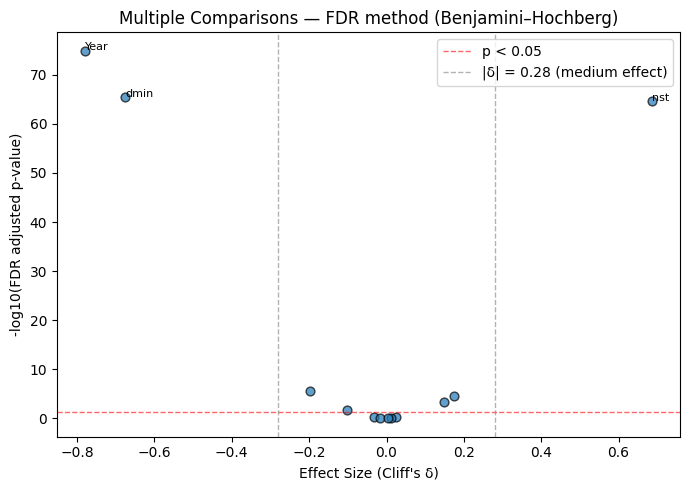

In [28]:
# --- Volcano Plot: effect size vs. adjusted p-value ---
def plot_effect_vs_p(tests_df, effect_col='effect_value', p_col='p_value', effect_threshold=0.28):
    """
    Displays a volcano plot of effect size versus -log10(FDR adjusted p-value),
    with lines indicating the minimum effect size threshold.
    """
    d = tests_df.dropna(subset=[effect_col, p_col]).copy()
    x = d[effect_col].values
    y = -np.log10(d[p_col].values + 1e-300)

    plt.figure(figsize=(7, 5))
    
    # Horizontal line (adjusted p < 0.05)
    plt.axhline(-np.log10(0.05), ls='--', lw=1, alpha=0.6, color='red', label='p < 0.05')

    # Vertical lines for medium effect size (|δ| = 0.28)
    plt.axvline(-effect_threshold, ls='--', lw=1, alpha=0.6, color='gray', label=f'|δ| = {effect_threshold} (medium effect)')
    plt.axvline(effect_threshold, ls='--', lw=1, alpha=0.6, color='gray')

    # Data points
    plt.scatter(x, y, s=40, alpha=0.7, edgecolor='k')
    
    # Labels for significant variables
    for _, row in d.iterrows():
        if row[p_col] < 0.05 and abs(row[effect_col]) >= effect_threshold:
            plt.text(row[effect_col], -np.log10(row[p_col]+1e-300)+0.1, 
                     row['variable'], fontsize=8)
    
    plt.xlabel("Effect Size (Cliff's δ)")
    plt.ylabel("-log10(FDR adjusted p-value)")
    plt.title("Multiple Comparisons — FDR method (Benjamini–Hochberg)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_effect_vs_p(tests_df)

The graph shows that the variables **dmin**, **nst**, and **Year** stand out due to their high statistical significance and medium-to-large effect sizes, exceeding the established thresholds; these observations remain consistent with what was previously noted in the statistical tests.

#### 3.1.4 Violin Plot

In this section, violin plots are used to represent the distributions of the variables showing the greatest differences between earthquakes that produced tsunamis and those that did not. This type of visualization allows for a comparison of both the dispersion and density of the data, complementing the statistical results obtained previously.

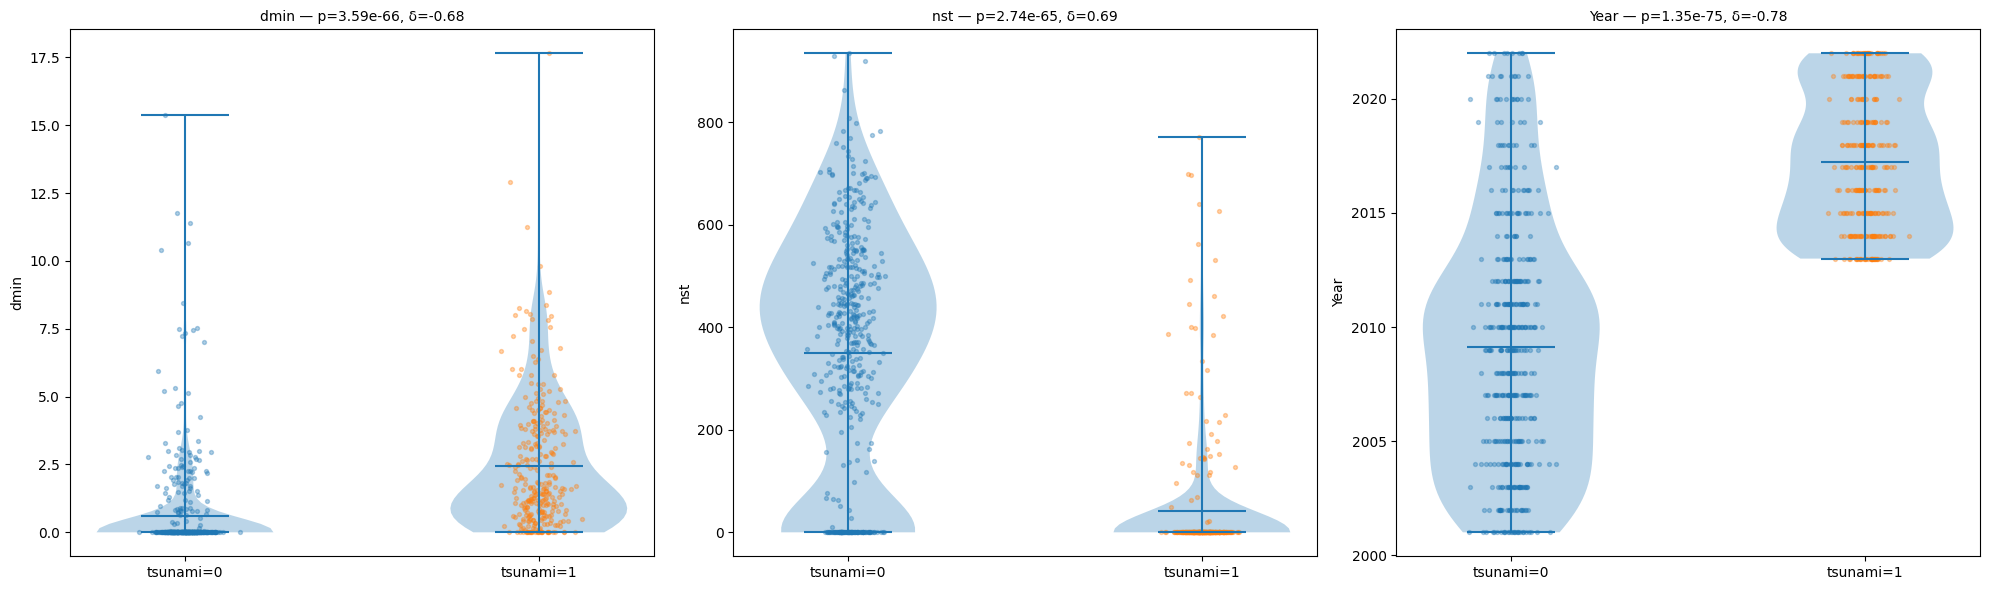

In [29]:
# --- Function to calculate effect size (Cliff’s delta) ---
def cliffs_delta(a, b):
    gt = sum(x > y for x, y in product(a, b))
    lt = sum(x < y for x, y in product(a, b))
    return (gt - lt) / (len(a) * len(b))

# --- Function to plot with Mann-Whitney and Cliff’s delta ---
def plot_mannwhitney_violin(df, value_col, group_col='tsunami', ax=None):
    d = df[[value_col, group_col]].dropna()
    a = d.loc[d[group_col] == 0, value_col].values
    b = d.loc[d[group_col] == 1, value_col].values
    
    U = stats.mannwhitneyu(a, b, alternative='two-sided')
    delta = cliffs_delta(a, b)

    # Create the axis if one is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))

    ax.violinplot([a, b], positions=[0, 1], showmeans=True)
    ax.scatter(np.full_like(a, 0) + np.random.randn(len(a)) * 0.04, a, s=8, alpha=0.35)
    ax.scatter(np.full_like(b, 1) + np.random.randn(len(b)) * 0.04, b, s=8, alpha=0.35)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'{group_col}=0', f'{group_col}=1'])
    ax.set_title(f"{value_col} — p={U.pvalue:.2e}, δ={delta:.2f}", fontsize=10)
    ax.set_ylabel(value_col)

# --- Variables to plot ---
vars_to_plot = ['dmin', 'nst', 'Year']

# --- Create figure with 3 subplots in a row ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, var in zip(axes, vars_to_plot):
    plot_mannwhitney_violin(df_orig, var, ax=ax)

plt.tight_layout()
plt.show()

The three graphs show clear differences between earthquakes that generated tsunamis and those that did not:

* **dmin (minimum distance to a station):** Events associated with tsunamis tend to occur further away from seismic stations, showing higher **dmin** values. This suggests they typically originate in more remote or marine areas.
* **nst (number of stations recording the event):** Earthquakes that generated tsunamis are detected by fewer stations, indicating lower instrumental coverage in the areas where they occur.
* **Year:** Tsunamis are primarily recorded in more recent years, reflecting technological improvements and an increased capacity to detect and record oceanic events over time, as previously explained.

**Conclusion:** The observed differences between the groups seem to stem primarily from geographic and temporal coverage factors, rather than inherent physical differences in the earthquakes themselves.

### 3.2 Do stronger or shallower earthquakes have a higher probability of generating tsunamis?

In this section, a Chi-square test is applied to verify whether the occurrence of tsunamis is associated with high-magnitude earthquakes ($mag\_high$, magnitude $\geq 7.0$) or shallow earthquakes ($depth\_shallow$, depth $\leq 70$ km).

In [30]:
df_th = df_orig.dropna().copy()
if {"magnitude","depth","tsunami"}.issubset(df_th.columns):
    df_th["mag_high"] = (df_th["magnitude"] >= 7.0).astype(int)
    df_th["depth_shallow"] = (df_th["depth"] <= 70).astype(int)
    from pandas import crosstab
    for var in ["mag_high","depth_shallow"]:
        ct = crosstab(df_th[var], df_th["tsunami"])
        chi2, p, dof, exp = stats.chi2_contingency(ct)
        print(var, "chi2=", round(chi2,3), "p=", p, "dof=", dof)
        display(ct)

mag_high chi2= 0.0 p= 1.0 dof= 1


tsunami,0,1
mag_high,,
0,305,194
1,173,110


depth_shallow chi2= 2.158 p= 0.1418170924814162 dof= 1


tsunami,0,1
depth_shallow,,
0,91,72
1,387,232


The results of the Chi-square test show that there is no statistically significant association between the magnitude or depth of the earthquake and the probability of generating a tsunami ($p > 0.05$ in both cases).

In other words, within this dataset, stronger earthquakes (magnitude $\geq 7.0$) or shallower ones (depth $\leq 70$ km) do not show a higher probability of causing tsunamis than others.

In these cells, two stacked bar charts are generated, showing side-by-side the proportion of tsunamis based on whether the earthquakes were of high magnitude ($\geq 7$) or shallow ($\leq 70$ km).

In [31]:
def plot_chi2_2x2_side_by_side(df):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
    vars_to_plot = [
        ("mag_high", "tsunami", "High Magnitude (≥ 7.0)"),
        ("depth_shallow", "tsunami", "Shallow Depth (≤ 70 km)")
    ]
    
    for ax, (binary_x, binary_y, title) in zip(axes, vars_to_plot):
        d = df[[binary_x, binary_y]].dropna().copy()
        d[binary_x] = d[binary_x].astype(int)
        d[binary_y] = d[binary_y].astype(int)

        ct = pd.crosstab(d[binary_x], d[binary_y])  # rows: x=0/1, cols: y=0/1
        chi2, p, dof, exp = stats.chi2_contingency(ct)

        props = ct.div(ct.sum(axis=1), axis=0)
        bottoms = np.zeros(len(props))
        for col in props.columns:
            ax.bar(props.index.astype(str), props[col].values, bottom=bottoms, label=f"{binary_y}={col}")
            bottoms += props[col].values

        for i, (_, vals) in enumerate(props.iterrows()):
            ax.text(i, vals[0]/2, f"{vals[0]:.2f}", ha='center', va='center', color='white', fontsize=9)
            ax.text(i, vals[0]+vals[1]/2, f"{vals[1]:.2f}", ha='center', va='center', color='white', fontsize=9)

        ax.set_title(f"{title}\nChi²={chi2:.2f}, p={p:.3g}")
        ax.set_ylabel("Proportion")
        ax.set_xlabel(binary_x)
        ax.legend(loc="upper right")

    plt.suptitle("Relationship between magnitude/depth and tsunami generation", fontsize=12)
    plt.show()

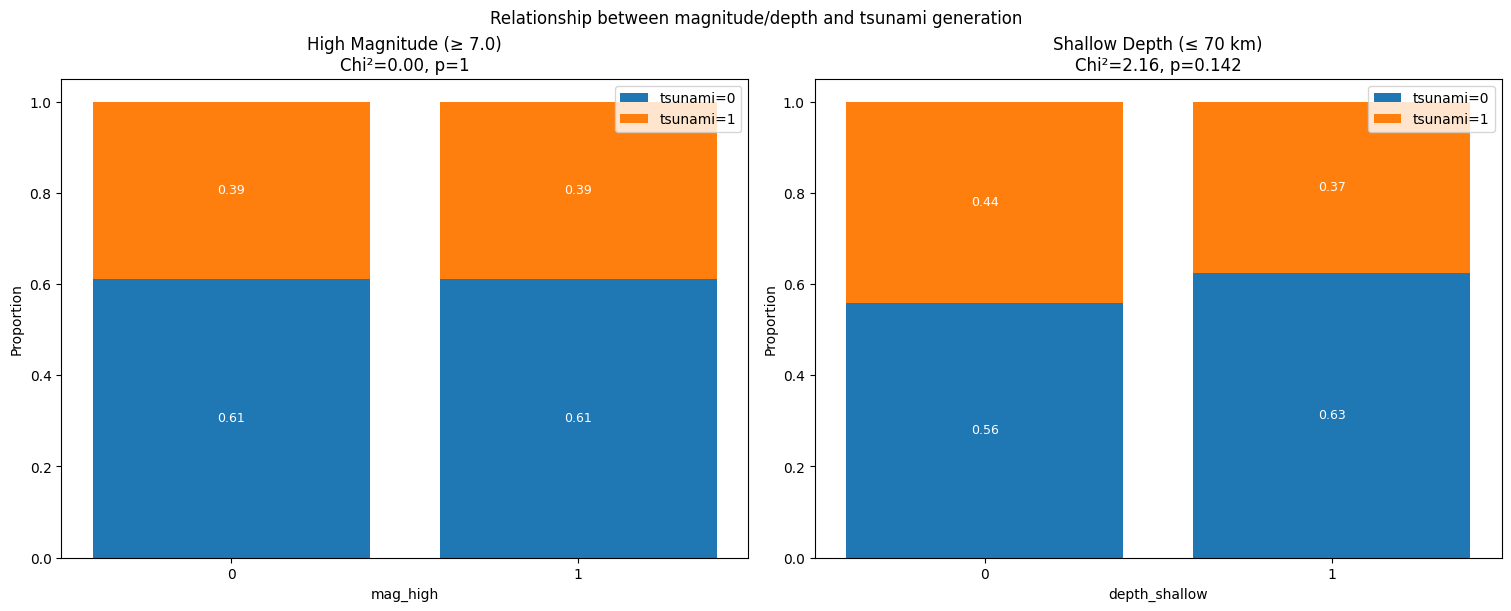

In [32]:
df_plot = df_orig.copy()
df_plot["mag_high"] = (df_plot["magnitude"] >= 7).astype(int)
df_plot["depth_shallow"] = (df_plot["depth"] <= 70).astype(int)

plot_chi2_2x2_side_by_side(df_plot)

The graphs highlight what was observed in the previous test: there are no significant differences in the proportion of tsunamis between high-magnitude earthquakes ($\geq 7.0$) and those of lower magnitude, nor between shallow earthquakes ($\leq 70$ km) and deeper ones.

## 4. Modeling `magnitude` — Linear, Regularization, and Non-Linear

### Features and auxiliary functions

In this section, various regression models are constructed with the objective of predicting earthquake magnitude based on the other variables in the dataset.

The process begins by applying a simple linear regression as a baseline model, followed by the evaluation of regularized versions (**Ridge** and **Lasso**) to manage potential issues with overfitting and multicollinearity. Additionally, variable selection techniques like Lasso are included to identify the most relevant features and optimize model performance.

**Note:** The variable `sig` will not be used in any of these models due to the **data leakage** (explained earlier) that it would create.

In [33]:
# For linear models, we EXCLUDE 'sig' due to data leakage
features_linear = ['depth', 'cdi', 'mmi', 'nst', 'dmin', 'gap', 'latitude', 'longitude', 'tsunami']

df_ml = df_orig.dropna().copy()
y = df_ml['magnitude']

# We perform a single index split and reuse it (same partition for all models)
idx_tr, idx_te = train_test_split(df_ml.index, test_size=0.20, random_state=42)

# Matrices for linear models (WITHOUT 'sig')
X_lin_tr = df_ml.loc[idx_tr, features_linear]
X_lin_te = df_ml.loc[idx_te, features_linear]
y_tr, y_te = y.loc[idx_tr], y.loc[idx_te]

Auxiliary functions to check normality and homoscedasticity of residuals, and to evaluate the models

In [34]:
def diag_residuos(model, X_te, y_te, name="Model"):
    """ Residual diagnostics:
    - Normality: Shapiro-Wilk + plots (histogram and QQ-plot)
    - Homoscedasticity: Breusch–Pagan + scatter residuals vs y_hat
    """
    y_hat = model.predict(X_te) if hasattr(model, "predict") else model.fit().predict(X_te)
    resid = y_te - y_hat
    n = len(resid)

    # ---- Normality (Shapiro)
    sh_stat, sh_p = (stats.shapiro(resid) if n <= 5000 else (np.nan, np.nan))

    # ---- Histogram + Q–Q in the SAME figure
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.hist(resid, bins=30, density=True, alpha=0.7)
    ax1.set_title(f"Residuals Histogram — {name}")

    ax2 = fig.add_subplot(1,2,2)
    sm.ProbPlot(resid).qqplot(line='45', alpha=0.4, lw=2, ax=ax2)
    ax2.set_title(f"Residuals Q–Q plot — {name}")
    plt.tight_layout(); plt.show()

    # ---- Homoscedasticity (Breusch–Pagan)
    X_aux = sm.add_constant(np.asarray(X_te))
    bp_stat, bp_p, _, _ = het_breuschpagan(resid, X_aux)

    # Residuals vs predictions
    plt.figure(figsize=(6,4))
    plt.scatter(y_hat, resid, alpha=0.6)
    plt.axhline(0, ls='--', color='red')
    plt.xlabel("Prediction (y_hat)"); plt.ylabel("Residual")
    plt.title(f"Residuals vs Prediction — {name}")
    plt.show()

    summary = pd.DataFrame({
        "test": ["Shapiro-Wilk", "Breusch–Pagan"],
        "stat": [sh_stat, bp_stat],
        "p_value": [sh_p, bp_p]
    })
    display(summary)

    return {"y_hat": y_hat, "resid": resid, "tests": summary}

def eval_model(nombre, modelo, Xte, yte):
    yhat = modelo.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, yhat))
    r2   = r2_score(yte, yhat)
    mae  = mean_absolute_error(yte, yhat)
    print(f"{nombre:>16}  RMSE: {rmse:.4f}   R²: {r2:.4f}   MAE: {mae:.4f}")
    return {"model": nombre, "RMSE": rmse, "R2": r2, "MAE": mae}

results = []

### 4.1 Modeling magnitude using linear regression

In this section, we aim to predict earthquake magnitude based on seismological and geographic variables. We begin with a baseline linear model to establish a reference point and, from there, test variants using regularization (**Ridge/Lasso**) and feature selection. Finally, we verify the residual assumptions (**normality and homoscedasticity**) and explore whether adding double interactions between predictors provides additional explanatory gain.

#### 4.1.1 Baseline Linear Model

In [35]:
lin = LinearRegression().fit(X_lin_tr, y_tr)
results.append(eval_model("Baseline Linear", lin, X_lin_te, y_te))

 Baseline Linear  RMSE: 0.3394   R²: 0.1656   MAE: 0.2753


The baseline linear model yields an **RMSE ≈ 0.34**, **MAE ≈ 0.27**, and **R² ≈ 0.17**, indicating low explanatory power. Consequently, we conduct a residual analysis to verify whether the classical model assumptions (**normality and homoscedasticity**) are met and to understand if the magnitude–predictor relationship might not be strictly linear or if relevant variables are missing.

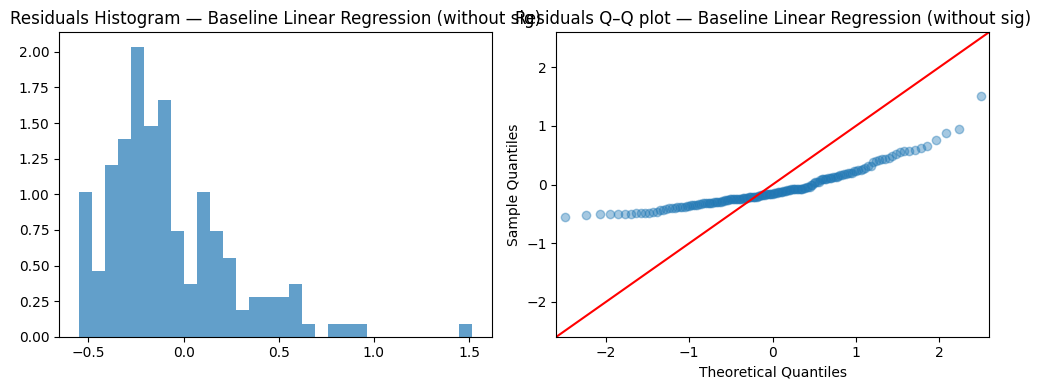

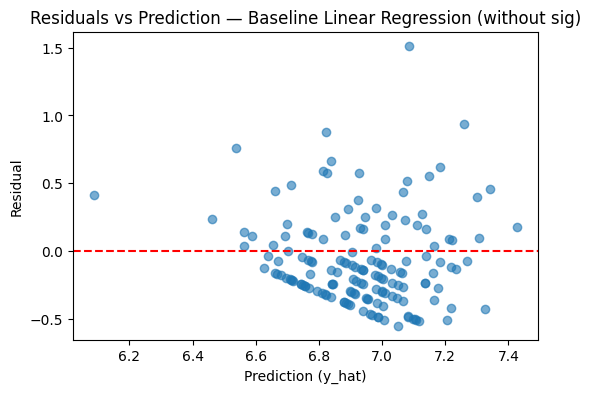

,test,stat,p_value
0,Shapiro-Wilk,0.900951,8.308486e-09
1,Breusch–Pagan,9.840216,3.635750e-01


In [36]:
_ = diag_residuos(lin, X_lin_te, y_te, name="Baseline Linear Regression (without sig)")

Regarding the assumptions, the Shapiro–Wilk test ($p < 0.001$) indicates that the residuals are not normal, which is also evident in the histogram and the Q–Q plot (noticeable deviations in the tails).

On the other hand, the Breusch–Pagan test ($p = 0.469$) does not reject homoscedasticity; that is, there is no evidence of non-constant variance. The residuals vs. prediction plot shows a relatively stable dispersion across the predictions.

As a next step, we test Ridge and Lasso regressions. Ridge can stabilize coefficients when correlated predictors are present; Lasso, in addition, can perform implicit variable selection (pushing coefficients to zero) and simplify the model. We evaluate whether these techniques improve performance and/or result in a more efficient set of predictors.

#### 4.1.2 Ridge / Lasso

In [37]:
sc = StandardScaler()
X_lin_tr_sc = sc.fit_transform(X_lin_tr)
X_lin_te_sc = sc.transform(X_lin_te)

ridge = Ridge(alpha=1.0).fit(X_lin_tr_sc, y_tr)
lasso = Lasso(alpha=0.01, max_iter=5000).fit(X_lin_tr_sc, y_tr)

for name, model in [("Ridge", ridge), ("Lasso", lasso)]:
    pred = model.predict(X_lin_te_sc)
    print(name, "RMSE:", round(np.sqrt(mean_squared_error(y_te, pred)), 3),
          "R2:", round(r2_score(y_te, pred), 3))

Ridge RMSE: 0.339 R2: 0.165
Lasso RMSE: 0.341 R2: 0.156


Ridge and Lasso achieve similar performance compared to the base model (R² ≈ 0.16–0.17). However, the residual assumptions still remain unmet (normality and homoscedasticity), so the practical gain is limited. Even so, Lasso is useful for identifying which variables provide the most information to the model.

The Lasso model applies a penalty that forces some coefficients to be exactly zero, which allows for identifying which variables are truly relevant for predicting the magnitude. The following table shows the estimated coefficients for each variable, ordered by their absolute magnitude. In this way, it is possible to observe which predictors retain weight in the model and which ones are eliminated due to their low explanatory contribution.

In [38]:
coef_df = pd.DataFrame({
    "Variable": X_lin_tr.columns,
    "Coefficient": lasso.coef_
}).sort_values("Coefficient", key=abs, ascending=False)

display(coef_df)

n_nozero = np.sum(lasso.coef_ != 0)
print(f"Number of variables selected by Lasso: {n_nozero} out of {len(lasso.coef_)} "
      f"({len(lasso.coef_) - n_nozero} variables eliminated).")

,Variable,Coefficient
2,mmi,0.130421
0,depth,0.078236
1,cdi,0.062152
3,nst,0.048060
5,gap,-0.040144
8,tsunami,0.020067
6,latitude,-0.011698
7,longitude,-0.003833
4,dmin,-0.000000


Number of variables selected by Lasso: 8 out of 9 (1 variables eliminated).


<Figure size 800x500 with 0 Axes>

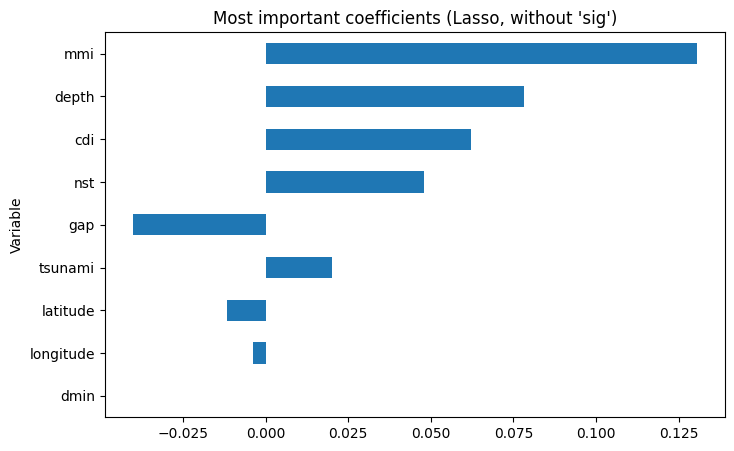

In [39]:
plt.figure(figsize=(8,5))
coef_df.head(11).plot(kind='barh', x='Variable', y='Coefficient', legend=False)
plt.title("Most important coefficients (Lasso, without 'sig')")
plt.gca().invert_yaxis()
plt.show()

The Lasso model results indicate that eight out of the nine original variables maintain a non-zero coefficient after regularization. Among the most influential are mmi (Mercalli intensity), depth, cdi (perceived intensity), and nst (number of stations), all of which have a positive effect on magnitude. Minor contributions are also observed from variables such as gap (negative), tsunami, latitude, and longitude, though with less weight. This reduction in the number of predictors improves interpretability without significantly affecting overall performance, maintaining a balance between simplicity and predictive capacity.

#### 4.1.3 Reduced Model

In [40]:
eps = 1e-8
sel_vars = X_lin_tr.columns[(np.abs(lasso.coef_) > eps)]
print("Vars selected by Lasso (without 'sig'):", list(sel_vars))

X_lin_tr_red = X_lin_tr[sel_vars].copy()
X_lin_te_red = X_lin_te[sel_vars].copy()

lin_red = LinearRegression().fit(X_lin_tr_red, y_tr)
pred_red = lin_red.predict(X_lin_te_red)

print("REDUCED Linear — RMSE:",
      round(np.sqrt(mean_squared_error(y_te, pred_red)), 3),
      "R2:", round(r2_score(y_te, pred_red), 3),
      "MAE:", round(mean_absolute_error(y_te, pred_red), 3))

Vars selected by Lasso (without 'sig'): ['depth', 'cdi', 'mmi', 'nst', 'gap', 'latitude', 'longitude', 'tsunami']
REDUCED Linear — RMSE: 0.339 R2: 0.166 MAE: 0.275


The reduced linear model, built with the variables selected by Lasso, maintains a very similar performance to the full model. The R² value barely changes and the mean error remains stable, indicating that the eliminated variables did not contribute relevant information for predicting magnitude. This result reinforces the utility of Lasso for simplifying the model without sacrificing explanatory power, allowing for a more compact and easy-to-interpret set of variables.

A continuación se amplía el modelo reducido incorporando interacciones dobles entre las variables seleccionadas por Lasso. 
El objetivo es explorar si la combinación de ciertos predictores puede capturar relaciones no lineales que un modelo lineal simple no logra representar. 
En este contexto, interacciones como profundidad con intensidad percibida (cdi), profundidad (depth) o la presencia de tsunami con la cobertura de red (gap) podrían reflejar efectos conjuntos relevantes. 
Con esta extensión se busca evaluar si la inclusión de estos términos mejora el poder predictivo manteniendo la estructura lineal del modelo.

#### 4.1.4 Double interactions in the reduced model

In [41]:
# --- Selected interactions ---
pairs = [
    ("depth", "cdi"),   # Depth × perceived intensity
    ("depth", "mmi"),   # Depth × Mercalli intensity
    ("nst", "gap"),     # Sensors × angular coverage
]

# --- Function to create interactions ---
def add_interactions(Xdf, pairs, prefix="int_"):
    X_new = Xdf.copy()
    for a, b in pairs:
        colname = f"{prefix}{a}__{b}"
        X_new[colname] = X_new[a] * X_new[b]
    return X_new

# --- Evaluation function ---
def eval_model(name, model, Xte, yte):
    yhat = model.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, yhat))
    r2   = r2_score(yte, yhat)
    mae  = mean_absolute_error(yte, yhat)
    print(f"{name:>28}  RMSE: {rmse:.3f}   R²: {r2:.3f}   MAE: {mae:.3f}")
    return rmse, r2, mae

# --- Previous scaling ---
scaler = StandardScaler()
X_tr_sc = pd.DataFrame(scaler.fit_transform(X_lin_tr_red), columns=X_lin_tr_red.columns, index=X_lin_tr_red.index)
X_te_sc = pd.DataFrame(scaler.transform(X_lin_te_red),     columns=X_lin_te_red.columns, index=X_lin_te_red.index)

# --- Add ONLY selected interactions ---
X_tr_int = add_interactions(X_tr_sc, pairs)
X_te_int = add_interactions(X_te_sc, pairs)

# --- Linear model without regularization ---
lin = LinearRegression().fit(X_tr_int, y_tr)

_ = eval_model("Linear (interactions)", lin, X_te_int, y_te)

       Linear (interactions)  RMSE: 0.343   R²: 0.150   MAE: 0.277


The reduced model with double interactions does not improve performance compared to the reduced linear model without interactions. 
In fact, the R² decreases slightly (from 0.167 to 0.151) and the RMSE increases (from 0.339 to 0.342), indicating that the combinations between variables such as depth–intensity 
or coverage–sensors do not provide additional relevant information for predicting magnitude. Consequently, the model's behavior suggests that the relationship between the explanatory variables and magnitude is fundamentally linear.

In [42]:
coef_lin = pd.Series(lin.coef_, index=X_tr_int.columns, name="coef_lin").sort_values(key=lambda s: s.abs(), ascending=False)
print("\nTop 12 coefficients (Linear):")
display(coef_lin.head(12).to_frame())


Top 12 coefficients (Linear):


,coef_lin
depth,0.178515
mmi,0.154666
cdi,0.078065
nst,0.066711
int_depth__cdi,0.058757
gap,-0.055501
int_depth__mmi,0.037623
tsunami,0.036436
latitude,-0.021043
int_nst__gap,-0.018888


En la inspección de los coeficientes, se observa que las variables individuales siguen siendo las más influyentes (especialmente depth, mmi y cdi), mientras que algunas interacciones como depth × cdi o depth × mmi presentan efectos menores pero no despreciables. Esto sugiere que la profundidad del evento podría modular parcialmente el efecto de la intensidad percibida y de la intensidad Mercalli en la magnitud, aunque estas interacciones no son lo bastante fuertes como para mejorar de forma sustancial la capacidad predictiva global del modelo.

To evaluate the validity of the reduced model with interactions, a residual analysis is performed using the same tests as in the previous models.

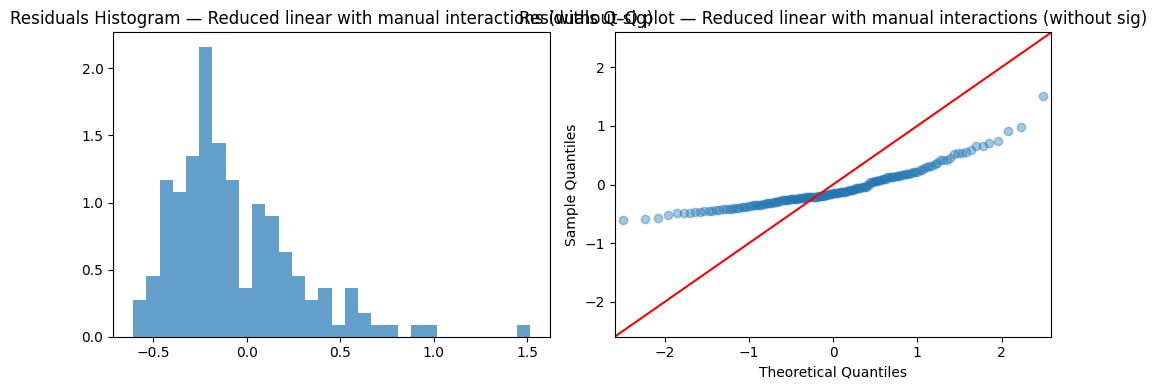

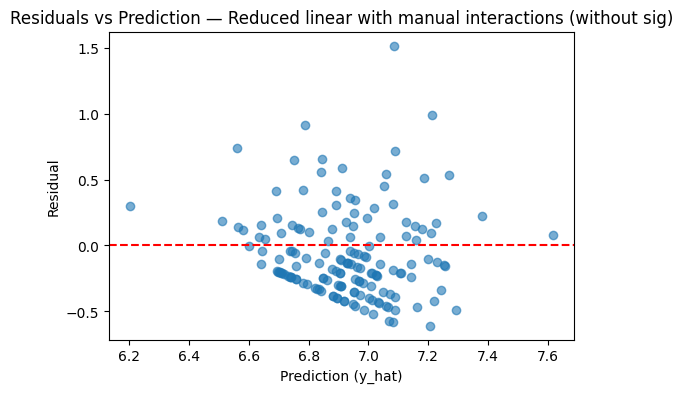

,test,stat,p_value
0,Shapiro-Wilk,0.908228,2.242917e-08
1,Breusch–Pagan,10.211613,5.114590e-01


In [43]:
# Residual diagnostics for the reduced model
_ = diag_residuos(lin, X_te_int, y_te, name="Reduced linear with manual interactions (without sig)")

The results of the residual analysis show that, although the incorporation of manual interactions does not correct the lack of normality, the model adequately meets the assumption of homoscedasticity.

The Shapiro–Wilk test (p < 0.001) and the Q–Q plot indicate that the residuals do not follow a normal distribution, with visible deviations in the tails relative to the theoretical line. However, the Breusch–Pagan test (p = 0.60) does not reject the hypothesis of homoscedasticity, suggesting that the variance of the errors remains approximately constant throughout the predictions.

Overall, the reduced linear model with manual interactions shows an improvement in residual stability compared to previous versions, although it explains less of the variance.

The set of linear models developed (base linear regression, Ridge, Lasso, and reduced versions with interactions) has allowed for exploring the relationship between earthquake magnitude and the various available variables. In general, the results obtained indicate that the explanatory power of linear models is quite limited, with low R² values and relatively high mean errors.

Overall, these results show that linear models offer a clear and easily communicable interpretation, but they do not adequately capture the non-linear relationships present in these data. Therefore, there is a need to explore more flexible models, such as Random Forest, which can model complex interactions and unexplained variability that the traditional linear approach misses.

### 4.2 Magnitude modeling using non-linear regression: Random Forest

After analyzing the linear models, we now seek to evaluate the capacity of a non-linear model to predict earthquake magnitude. In particular, a Random Forest Regressor is used, an ensemble method based on decision trees that allows for capturing non-linear and complex relationships between predictor variables.

In [44]:
rf_reg = RandomForestRegressor(n_estimators=300, random_state=42).fit(X_lin_tr, y_tr)
pred_rf = rf_reg.predict(X_lin_te)
print("RFReg RMSE:", round(np.sqrt(mean_squared_error(y_te, pred_rf)), 3),
      "R2:", round(r2_score(y_te, pred_rf), 3))

RFReg RMSE: 0.298 R2: 0.356


The Random Forest model shows a clearly superior performance compared to the linear models, with an R² ≈ 0.34 compared to values below 0.17 in previous models.
Despite this, the predictive capacity remains limited, suggesting that the available variables do not contain enough information to estimate the magnitude accurately.

### Variable importance analysis

In [45]:
imp = (pd.DataFrame({
    "Variable": X_lin_tr.columns,
    "Importance": rf_reg.feature_importances_
}).sort_values("Importance", ascending=False))

display(imp.head(15))

,Variable,Importance
0,depth,0.193869
6,latitude,0.152922
1,cdi,0.137341
7,longitude,0.128381
5,gap,0.119383
2,mmi,0.106761
3,nst,0.104024
4,dmin,0.047685
8,tsunami,0.009635


<Figure size 800x500 with 0 Axes>

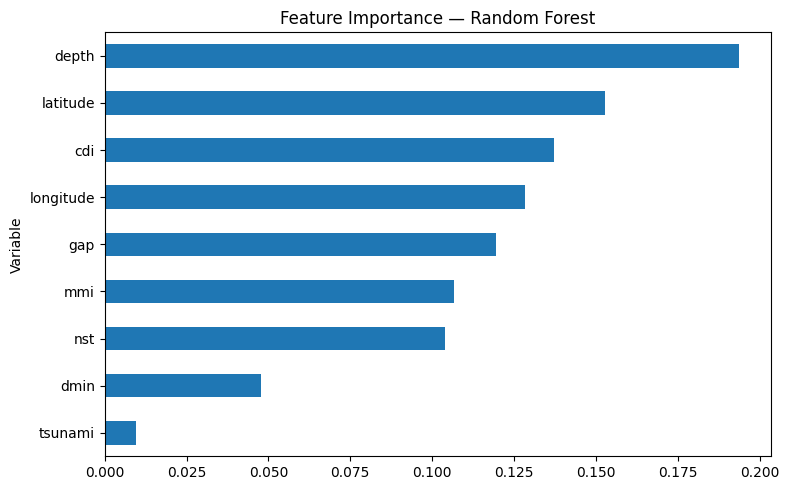

In [46]:
plt.figure(figsize=(8,5))
imp.head(12).sort_values("Importance").plot(kind="barh", x="Variable", y="Importance", legend=False)
plt.title("Feature Importance — Random Forest")
plt.tight_layout()
plt.show()

The variable importance analysis shows that depth, latitude, cdi, and longitude are the most relevant predictors in estimating magnitude. Variables such as gap, mmi, and nst also add value, while tsunami and dmin have a lower predictive weight.

The variable importance analysis shows that depth, latitude, cdi, and longitude are the most relevant predictors in estimating magnitude. Variables such as gap, mmi, and nst also add value, while tsunami and dmin have a lower predictive weight.

In conclusion, satisfactory results were not obtained when attempting to model earthquake magnitude through regression. Despite applying both linear and non-linear models, the predictive capacity remains limited. This may be due to the available variables not adequately capturing the physical and geological factors that determine the true magnitude of the event.

## 5. PCA

PCA (Principal Component Analysis) is a dimensionality reduction method that defines linear combinations of the original variables called principal components, which more effectively represent the underlying variability.

In this case, we apply PCA to explore the internal structure of the seismic data and check if there are patterns that differentiate events associated with tsunamis from those that do not generate them.

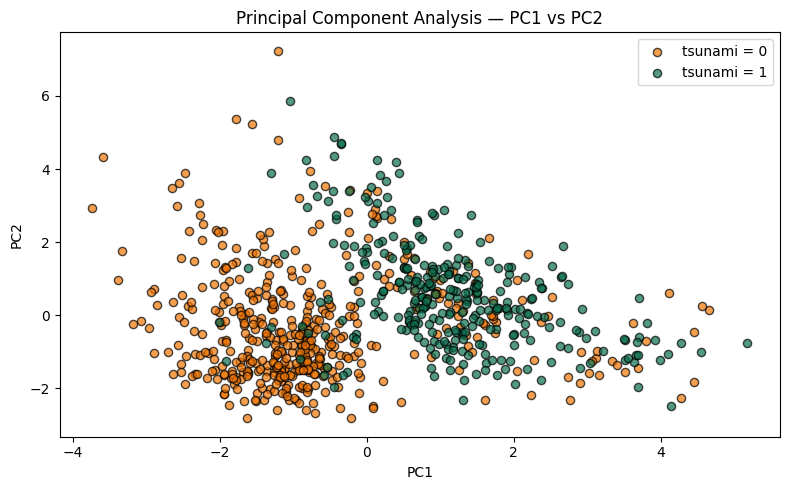

In [47]:
feat_all = [c for c in df_ml.columns if c != "tsunami"]
Xs = StandardScaler().fit_transform(df_ml[feat_all])
pca2 = PCA(n_components=2)
Xp = pca2.fit_transform(Xs)

plt.figure()
colors = ["#F07605", "#0B6E4F"]
for cls in [0, 1]:
    idx = (df_ml["tsunami"].values == cls)
    plt.scatter(
        Xp[idx, 0], Xp[idx, 1], 
        c=colors[cls], s=35, alpha=0.7,
        edgecolors="#000000", label=f"tsunami = {cls}"
    )

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Principal Component Analysis — PC1 vs PC2")
plt.legend()
plt.tight_layout()
plt.show()

In the PC1–PC2 plane, two partially overlapping clouds are observed. The greatest dispersion aligns with PC1, indicating that this first component concentrates most of the dataset's variability. There is some separation along PC1 between observations with tsunami = 0 and tsunami = 1, but it is not perfect: there is an appreciable overlap, so a clear discrimination of the class is not achieved with only two components. Overall, the plot suggests that global patterns exist in the data, although the presence of a tsunami depends on more complex relationships that are not fully captured by a linear projection on two axes. For this reason, we will next consult PC3 and visualize the 3D scatter plot; if the third component adds signal, the separation might become more visible when using (PC1, PC2, PC3).

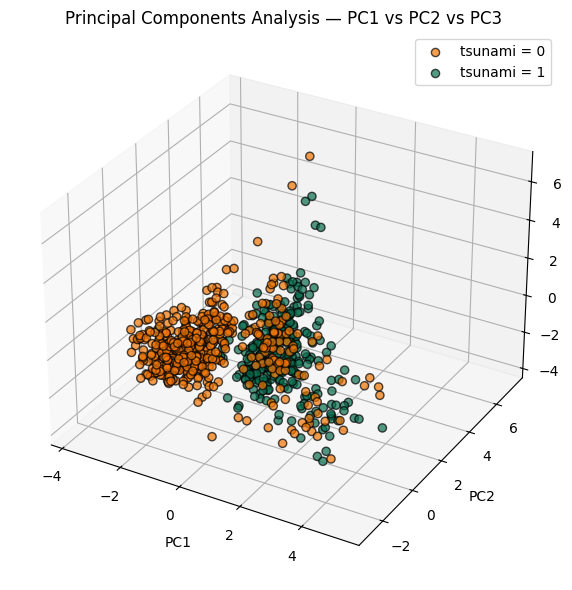

In [48]:
pca3 = PCA(n_components=3)
Xp = pca3.fit_transform(Xs)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
colors = ["#F07605", "#0B6E4F"]
for cls in [0, 1]:
    idx = (df_ml["tsunami"].values == cls)
    ax.scatter(
        Xp[idx, 0], Xp[idx, 1], Xp[idx, 2],
        c=colors[cls], s=35, alpha=0.7,
        edgecolors="#000000", label=f"tsunami = {cls}"
    )
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Principal Components Analysis — PC1 vs PC2 vs PC3")
ax.legend()
plt.tight_layout()
plt.show()


The three-dimensional projection allows for a better observation of the distribution of events in the space formed by the first three principal components. By adding PC3, a slight improvement in the separation between points corresponding to tsunamis (green) and non-tsunamis (orange) is observed.

Although the clouds still show some overlap, this 3D visualization reveals that the data do contain differentiable patterns in additional dimensions that were not fully captured in the previous two-dimensional plane.

For this reason, we decided to calculate the PCA considering all components, with the objective of quantifying how much total variance is explained by the main directions of the data and determining how many are necessary to represent the majority of the information without losing relevance.

In [49]:
# PCA with all components (after scaling: Xs)
pca_full = PCA().fit(Xs)

# Explained variance per component and cumulative variance
exp_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

# Summary table
var_df = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(len(exp_var))],
    "Explained_variance": exp_var,
    "Cumulative_variance": cum_var
})
display(var_df.head(10))

,Component,Explained_variance,Cumulative_variance
0,PC1,0.216833,0.216833
1,PC2,0.194762,0.411595
2,PC3,0.110281,0.521875
3,PC4,0.092310,0.614186
4,PC5,0.083519,0.697704
5,PC6,0.081230,0.778935
6,PC7,0.054381,0.833315
7,PC8,0.053435,0.886751
8,PC9,0.037213,0.923963
9,PC10,0.031638,0.955601


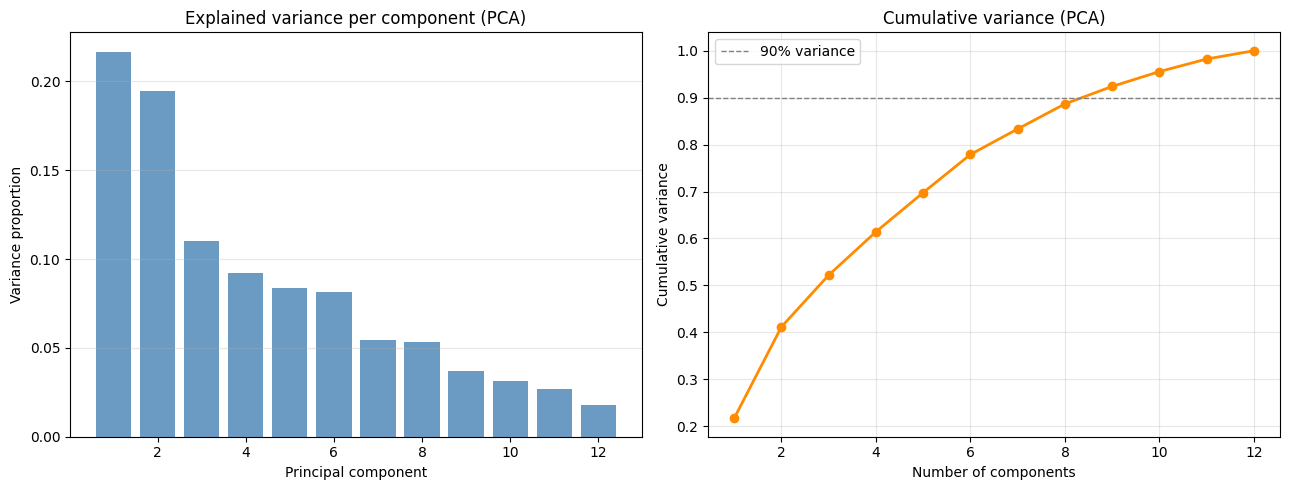

In [50]:
# --- Separate plots for better clarity ---
fig, axes = plt.subplots(1, 2, figsize=(13,5))

# Plot 1: Explained variance per component
axes[0].bar(np.arange(1, len(exp_var)+1), exp_var, color="#4682B4", alpha=0.8)
axes[0].set_title("Explained variance per component (PCA)")
axes[0].set_xlabel("Principal component")
axes[0].set_ylabel("Variance proportion")
axes[0].grid(axis="y", alpha=0.3)

# Plot 2: Cumulative variance
axes[1].plot(np.arange(1, len(cum_var)+1), cum_var, marker="o", color="#FF8C00", linewidth=2)
axes[1].set_title("Cumulative variance (PCA)")
axes[1].set_xlabel("Number of components")
axes[1].set_ylabel("Cumulative variance")
axes[1].grid(alpha=0.3)
axes[1].axhline(0.9, color="gray", linestyle="--", linewidth=1, label="90% variance")
axes[1].legend()

plt.tight_layout()
plt.show()

The explained variance plot shows that the first two components concentrate about 40% of the total variability, while the first five exceed 75%. This indicates that a large part of the original data information can be represented in a relatively low-dimensional space. However, if one wished to explain at least 90% of the total variance, it would be necessary to include at least the first nine principal components, which would involve working in a higher-dimensional space.

## 6. Clustering

Clustering is an unsupervised learning technique that groups observations with similar characteristics without the need for prior labels. 
In this context, we apply it to identify geographical regions with similar seismic behavior, based on the coordinates (latitude and longitude) of the earthquakes.

The main objective is to detect spatial patterns that correspond to subduction zones or regions with high seismic activity, which helps to better understand the global distribution of tsunami risk.

### 6.1 Auxiliary functions

In [51]:
def latlon_to_unit(lat_deg, lon_deg):
    """Converts lat/lon in degrees to 3D coordinates (x,y,z) on the unit sphere."""
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return np.c_[x, y, z]  # shape (n,3)

def unit_to_latlon(U):
    """Converts 3D coordinates (x,y,z) back to lat/lon (degrees)."""
    x, y, z = U[:, 0], U[:, 1], U[:, 2]
    lat = np.degrees(np.arctan2(z, np.sqrt(x*x + y*y)))
    lon = np.degrees(np.arctan2(y, x))
    return np.c_[lat, lon]

### 6.2 Elbow method

In this section, we apply the Elbow method to estimate the optimal number of clusters (k) when grouping earthquake epicenters.

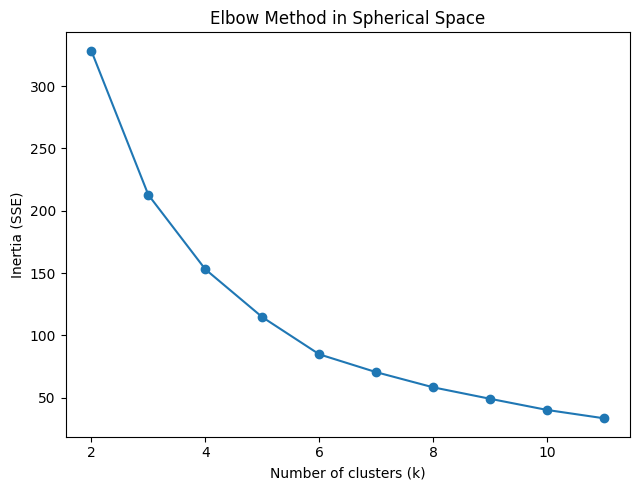

In [52]:
# === Data Preparation ===
lat = df["latitude"].values
lon = df["longitude"].values
U = latlon_to_unit(lat, lon)

# === Elbow Method ===
k_values = list(range(2, 12))
inertias = []

for k_ in k_values:
    km_ = KMeans(n_clusters=k_, n_init=20, random_state=42).fit(U)
    inertias.append(km_.inertia_)

plt.figure(figsize=(6.5, 5))
plt.plot(k_values, inertias, marker="o")
plt.title("Elbow Method in Spherical Space")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.tight_layout()
plt.show()

In the Elbow method plot, we observe how the inertia (SSE) decreases rapidly as we increase the number of clusters, but without a clearly defined inflection point ("elbow").

Since the curve descends more or less continuously, there is no value of k that visually stands out as optimal. For this reason, to select the number of clusters more objectively, we proceed to apply the Silhouette method, which evaluates the quality of separation between groups.

### 6.3 Silhouette Method

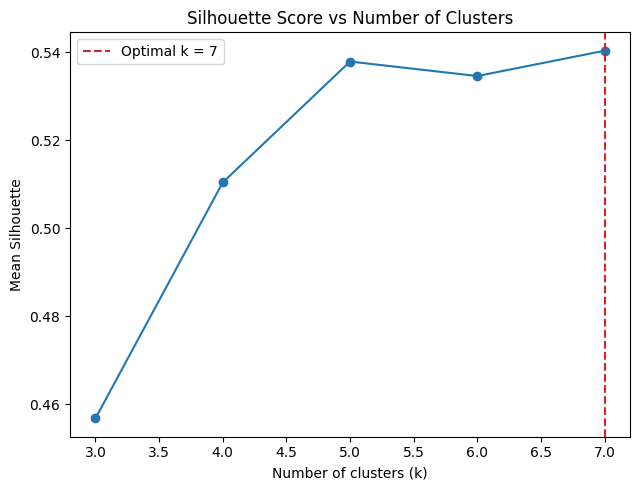

Best k by silhouette: 7 (score=0.540)
         centroid_lat  centroid_lon  size
cluster                                  
0           53.073482   -151.368696    50
1            1.001317    115.110404   164
2          -31.895373    -65.748660    91
3          -16.300450    165.109458   235
4           38.760707    137.559746   107
5           33.747056     54.212652    53
6           12.541090    -87.331017    82


In [53]:
# === Silhouette Method ===
best_k, best_s = None, -1
silhouettes = []

for k in range(3, 8):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    lbl = km.fit_predict(U)
    s = silhouette_score(U, lbl)
    silhouettes.append(s)
    if s > best_s:
        best_k, best_s = k, s

plt.figure(figsize=(6.5, 5))
plt.plot(range(3, 8), silhouettes, marker="o")
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Mean Silhouette")
plt.axvline(best_k, color="tab:red", linestyle="--", label=f"Optimal k = {best_k}")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best k by silhouette: {best_k} (score={best_s:.3f})")

# === Final Fit with Optimal k ===
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(U)

labels = kmeans.labels_
centers_unit = kmeans.cluster_centers_
centers_latlon = unit_to_latlon(centers_unit)

# === Cluster Summary ===
summary = (
    pd.DataFrame(centers_latlon, columns=["centroid_lat", "centroid_lon"])
    .assign(size=pd.Series(labels).value_counts().sort_index().values)
)
summary.index.name = "cluster"
print(summary)

The Silhouette method shows that the maximum value of the index is reached at k = 7, with an average score of 0.54, indicating a moderately good separation between groups. 

Therefore, we adopt k = 7 as the optimal number of clusters, as it offers a reasonable balance between internal cohesion and separation between groups.

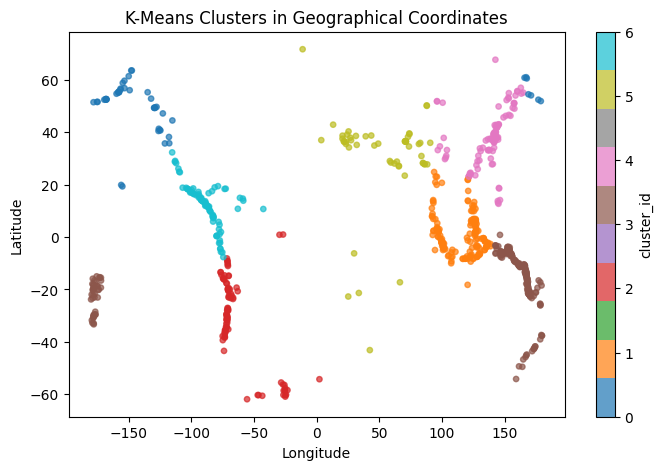

In [54]:
plt.figure(figsize=(8,5))
sc = plt.scatter(df["longitude"], df["latitude"], c=labels, s=15, alpha=0.7, cmap="tab10")
plt.colorbar(sc, label="cluster_id")
plt.title("K-Means Clusters in Geographical Coordinates")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()

In this plot, the seven clusters are observed distributed along the planet's main seismic zones.
Although the general pattern suggests coherent groupings, it is not easy to appreciate their exact relationship with tectonic regions without a real geographical reference.
To correctly interpret the results, we will re-plot the clusters on a world map, also adding the position of the centroids calculated by the algorithm.

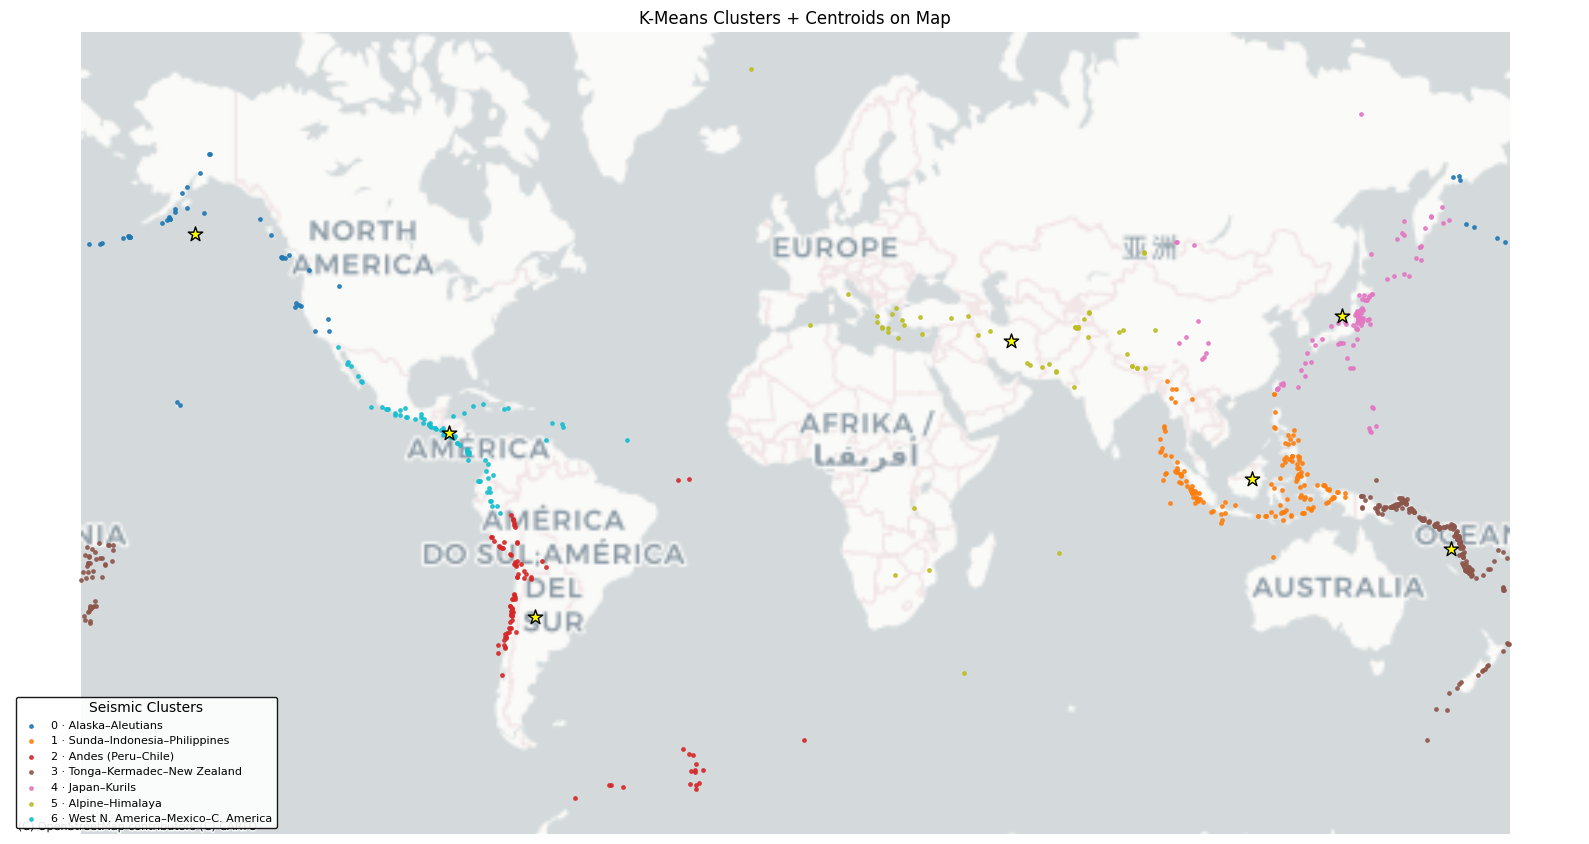

In [55]:
# === K-Means Clusters Map with Centroids ===
df_map = df.dropna(subset=["latitude", "longitude"]).copy() 
df_map["cluster_id"] = labels  # K-Means model labels
df_map["date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))

# --- Descriptive Names ---
cluster_names = {
    0: "Alaska–Aleutians",
    1: "Sunda–Indonesia–Philippines",
    2: "Andes (Peru–Chile)",
    3: "Tonga–Kermadec–New Zealand",
    4: "Japan–Kurils",
    5: "Alpine–Himalaya",
    6: "West N. America–Mexico–C. America",
}

def id2label(i):
    return f"{i} · {cluster_names.get(int(i), 'Cluster')}"

# --- GeoDataFrames ---
gdf = gpd.GeoDataFrame(
    df_map,
    geometry=[Point(xy) for xy in zip(df_map["longitude"], df_map["latitude"])],
    crs="EPSG:4326"
).to_crs(3857)

centers_df = pd.DataFrame(centers_latlon, columns=["lat", "lon"])
gdf_cent = gpd.GeoDataFrame(
    centers_df,
    geometry=[Point(xy) for xy in zip(centers_df["lon"], centers_df["lat"])],
    crs="EPSG:4326"
).to_crs(3857)

# --- Combined Plot ---
fig, ax = plt.subplots(figsize=(16, 12))

# Assign a color palette (matching tab10)
palette = plt.get_cmap("tab10", len(cluster_names))

# Plot each cluster with its color and name
for i, name in cluster_names.items():
    subset = gdf[gdf["cluster_id"] == i]
    subset.plot(ax=ax, color=palette(i), markersize=6, alpha=0.85, label=f"{i} · {name}")

# Plot centroids
gdf_cent.plot(ax=ax, color="yellow", edgecolor="black", markersize=120, marker="*")

# Map base
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("K-Means Clusters + Centroids on Map")

# --- Custom Legend ---
leg = ax.legend(
    title="Seismic Clusters",
    loc="lower left",
    fontsize=8,
    title_fontsize=10,
    frameon=True
)
leg.get_frame().set_alpha(0.9)
leg.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.show()

The map shows a clear correspondence between the identified clusters and the planet's main subduction zones:

- In the Western Pacific, several groups coincide with the Japan, Philippines, and Tonga–Kermadec arcs—regions with a high incidence of tsunamis.
- Another group extends along the western coast of the Americas, spanning from Alaska to Chile, associated with the Pacific Ring of Fire.
- Distinct groupings are also visible in the Indian Ocean (Sumatra) and the Caribbean, both of which have a history of significant tsunamis.

The centroids (yellow stars) are located in positions consistent with the most intense centers of seismic activity. This suggests that the K-Means model on spherical coordinates has successfully captured the primary global zones of seismic and tsunamigenic risk.

In conclusion, the result obtained is consistent with geophysical reality, and the seven identified clusters approximately correspond to the planet's main subduction arcs.

### 6.4 Temporal Analysis of Seismic Activity by Cluster

Starting from the observation that major earthquakes tend to cluster in specific geographical areas and that, in some cases, one event may precede others occurring later in nearby regions—or even in distant regions given enough time—the hypothesis is raised that temporal or sequential patterns might exist among the seismic clusters identified in the previous section.

In other words, the goal is to check whether earthquakes propagate or "chain" between different areas of the planet, as if there were a temporal relationship between the main subduction zones.

In this plot, the temporal evolution of seismic activity is represented for each cluster, where the size and color of the points reflect the number of earthquakes recorded each month, with the objective of observing possible patterns.

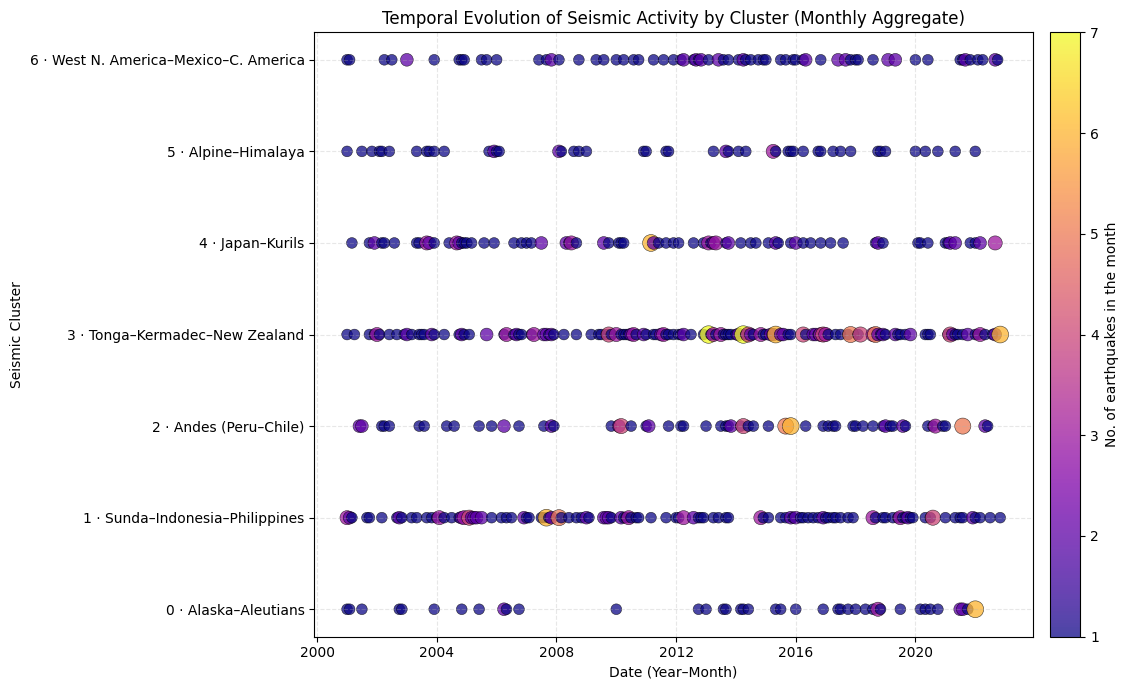

In [56]:
# --- Group by month and cluster ---
activity = df_map.groupby(["date", "cluster_id"]).size().reset_index(name="count")

# --- Color scale proportional to the number of earthquakes ---
cmin, cmax = activity["count"].min(), activity["count"].max()
norm = Normalize(vmin=cmin, vmax=cmax)
cmap = plt.get_cmap("plasma")

# Colors and sizes smoothly scaled
colors = cmap(norm(activity["count"]))
sizes = 60 * np.sqrt(activity["count"])

# --- Create figure and axes ---
fig, ax = plt.subplots(figsize=(12, 7))

# --- Scatter plot ---
sc = ax.scatter(
    activity["date"],
    activity["cluster_id"],
    s=sizes,
    c=activity["count"],     # directly use values for the colorbar
    cmap=cmap,
    alpha=0.75,
    edgecolor="k",
    linewidth=0.4
)

# --- Axes and labels ---
ax.set_yticks(range(len(cluster_names)))
ax.set_yticklabels([f"{i} · {cluster_names[i]}" for i in range(len(cluster_names))])
ax.set_xlabel("Date (Year–Month)")
ax.set_ylabel("Seismic Cluster")
ax.set_title("Temporal Evolution of Seismic Activity by Cluster (Monthly Aggregate)")

# --- Colorbar linked to the scatter ---
cbar = fig.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label("No. of earthquakes in the month")

ax.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

The plot shows the temporal distribution of earthquakes in each cluster, but no clear pattern or evident sequential relationship between regions is observed; therefore, it is not possible to draw significant conclusions from this visualization.

Since the previous plot did not identify any clear pattern or evident temporal relationship between clusters, this section builds a transition matrix to analyze the probability that the dominant seismic activity in a given month is followed, in the subsequent month, by activity in another cluster.

To do this, we consider the full monthly sequence without distinguishing between years, so that transitions are calculated from one month to the next continuously throughout the entire time series. This allows for estimating the global transition probability between seismic regions without segmenting by specific years, as the focus is not on the annual cycle, but on the general temporal succession of activity patterns between clusters.

The objective of this matrix is to identify recurring trends or relationships in the global evolution of seismic activity across different areas of the planet.

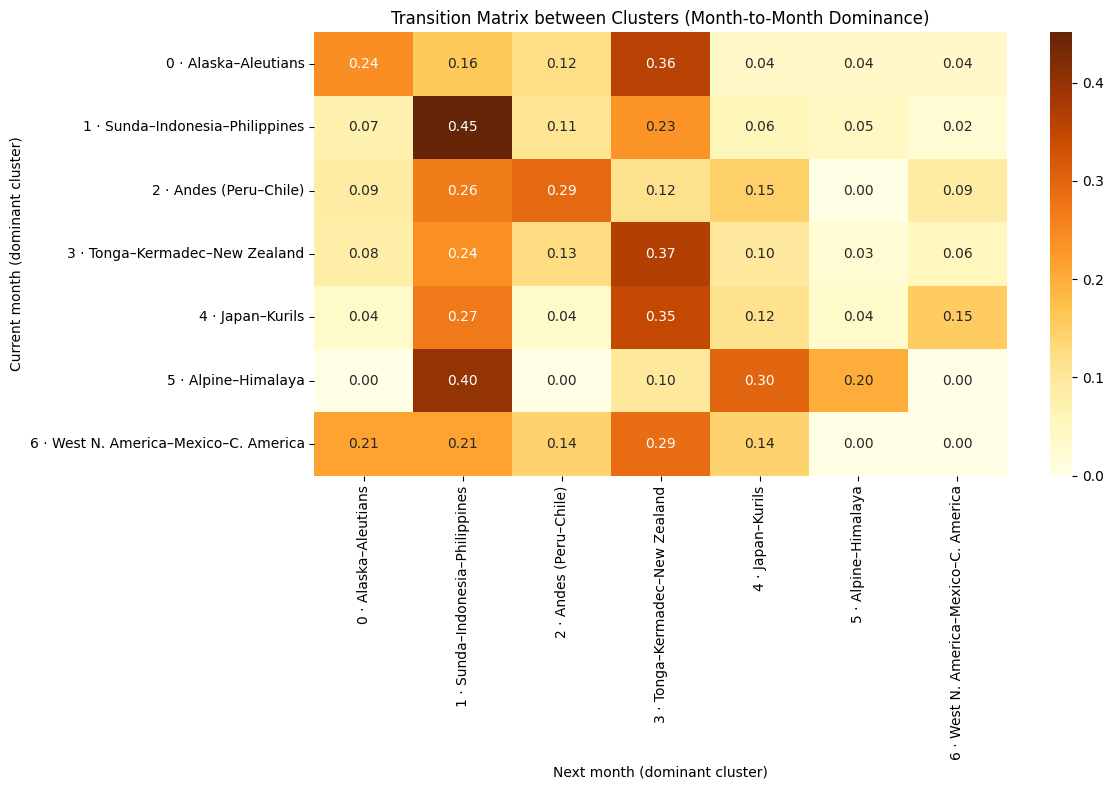

Top transitions (A→B, probability):
  1 · Sunda–Indonesia–Philippines → 1 · Sunda–Indonesia–Philippines: 0.45
  5 · Alpine–Himalaya → 1 · Sunda–Indonesia–Philippines: 0.40
  3 · Tonga–Kermadec–New Zealand → 3 · Tonga–Kermadec–New Zealand: 0.37
  0 · Alaska–Aleutians → 3 · Tonga–Kermadec–New Zealand: 0.36
  4 · Japan–Kurils → 3 · Tonga–Kermadec–New Zealand: 0.35
  5 · Alpine–Himalaya → 4 · Japan–Kurils: 0.30
  2 · Andes (Peru–Chile) → 2 · Andes (Peru–Chile): 0.29
  6 · West N. America–Mexico–C. America → 3 · Tonga–Kermadec–New Zealand: 0.29
  4 · Japan–Kurils → 1 · Sunda–Indonesia–Philippines: 0.27
  2 · Andes (Peru–Chile) → 1 · Sunda–Indonesia–Philippines: 0.26


In [57]:
# Monthly series of dominant clusters
# Calculate the dominant cluster per month
idx = activity.groupby("date")["count"].idxmax()
dom = activity.loc[idx, ["date","cluster_id"]].sort_values("date").copy()

# Resample to ensure a continuous monthly sequence and forward-fill if necessary
dom_m = dom.set_index("date").resample("MS").first().ffill()
dom_m["cluster_id"] = dom_m["cluster_id"].astype(int)

# Create transition pairs (current month -> next month)
pairs = list(zip(dom_m["cluster_id"][:-1], dom_m["cluster_id"][1:]))

K = int(activity["cluster_id"].max()) + 1
M = np.zeros((K, K), dtype=int)
for a, b in pairs:
    M[int(a), int(b)] += 1

# Normalize to get probabilities
row_sums = M.sum(axis=1, keepdims=True)
P = np.divide(M, row_sums, out=np.zeros_like(M, dtype=float), where=row_sums != 0)

import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(
    P, annot=True, fmt=".2f", cmap="YlOrBr",
    xticklabels=[id2label(i) for i in range(K)],
    yticklabels=[id2label(i) for i in range(K)]
)
plt.xlabel("Next month (dominant cluster)")
plt.ylabel("Current month (dominant cluster)")
plt.title("Transition Matrix between Clusters (Month-to-Month Dominance)")
plt.tight_layout()
plt.show()

# Top transitions with names
top = [(i, j, P[i, j]) for i in range(K) for j in range(K) if P[i, j] > 0]
top = sorted(top, key=lambda x: x[2], reverse=True)[:10]

print("Top transitions (A→B, probability):")
for a, b, p in top:
    print(f"  {id2label(a)} → {id2label(b)}: {p:.2f}")

The transition matrix reveals that while certain local persistence trends exist—such as in the Sunda–Indonesia–Philippines (0.45) and Tonga–Kermadec–New Zealand (0.37) clusters—overall transition probabilities are moderate, and none exceed 0.5. This indicates that there is no strong temporal continuity or clear dependency between consecutive months; that is, the dominant cluster in one month does not predict the following month's dominant cluster with high probability.

Even so, slight connections are observed between Western Pacific zones (for example, Alaska–Aleutians → Tonga–Kermadec–New Zealand or Alpine–Himalaya → Japan–Kurils). This suggests some geographical coherence, though without solid evidence of a global sequence or significant temporal propagation between seismic regions.

## 7. Tsunami Classification — Logistic Regression (L1/L2), RandomForest, XGBoost/GB

In this section, we aim to build and compare different classification models capable of predicting the occurrence of a tsunami associated with an earthquake. 
To do this, several algorithms are trained and their performance is evaluated using metrics such as precision, recall, F1-score, and the area under the ROC curve (AUC-ROC).

The objective is to identify which model offers the best predictive capability and to understand which variables have the greatest influence on tsunami generation.

### 7.1 Data Preparation and Auxiliary Functions

In [58]:
features_clf = ['magnitude','depth','cdi','mmi','nst','dmin','gap','latitude','longitude']
dfc = df_orig.dropna().copy()
Xc, yc = dfc[features_clf], dfc["tsunami"]

# Stratify the split to maintain class proportions (tsunami/no-tsunami)
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(Xc, yc, test_size=0.2, stratify=yc, random_state=42)
sc2 = StandardScaler()
Xc_tr_sc, Xc_te_sc = sc2.fit_transform(Xc_tr), sc2.transform(Xc_te)

def eval_clf(y_true, y_pred, y_prob, name):
    # === Main Metrics ===
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_prob)
    print(f"{name} -> Acc:{acc:.3f} Prec:{prec:.3f} Rec:{rec:.3f} F1:{f1:.3f} AUC:{roc:.3f}")

    # === Side-by-side Plots ===
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    axes[0].imshow(cm, cmap="Blues")
    axes[0].set_title(f"Confusion Matrix — {name}")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha='center', va='center', color="black")

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes[1].plot(fpr, tpr, label=f"AUC = {roc:.3f}")
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_title(f"ROC Curve — {name}")
    axes[1].set_xlabel("FPR")
    axes[1].set_ylabel("TPR")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### 7.2 Classification using Logistic Regression

In this section, the logistic regression model is applied, using both L1 and L2 regularization, to classify seismic events according to the probability that they will generate a tsunami.

#### 7.2.1 Logistic Regression L1

Logistic regression with L1 regularization is applied.

Logistic (L1) -> Acc:0.822 Prec:0.720 Rec:0.885 F1:0.794 AUC:0.882


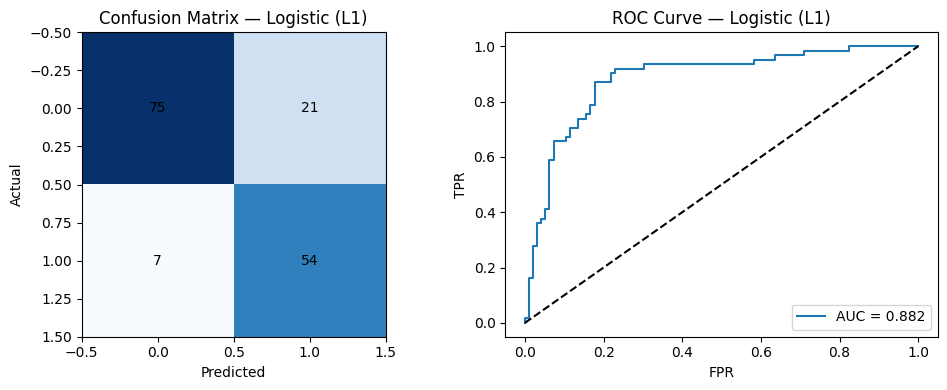

In [59]:
log_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000).fit(Xc_tr_sc, yc_tr)
yp_l1 = log_l1.predict(Xc_te_sc); ypb_l1 = log_l1.predict_proba(Xc_te_sc)[:,1]
eval_clf(yc_te, yp_l1, ypb_l1, "Logistic (L1)")

The logistic regression model with L1 regularization achieves a solid performance with 82% accuracy and an Area Under the ROC Curve (AUC) of 0.88, indicating a very good ability to discriminate between events with and without a tsunami.

The confusion matrix shows that the model correctly predicts most cases, although it presents some false positives (predicting a tsunami when there was none) and few false negatives.

The ROC curve shows a clear separation from the random diagonal line, evidencing a robust behavior of the classifier.

#### 7.2.2 Logistic Regression L2

Logistic regression with L2 regularization is applied.

Logistic (L2) -> Acc:0.815 Prec:0.716 Rec:0.869 F1:0.785 AUC:0.881


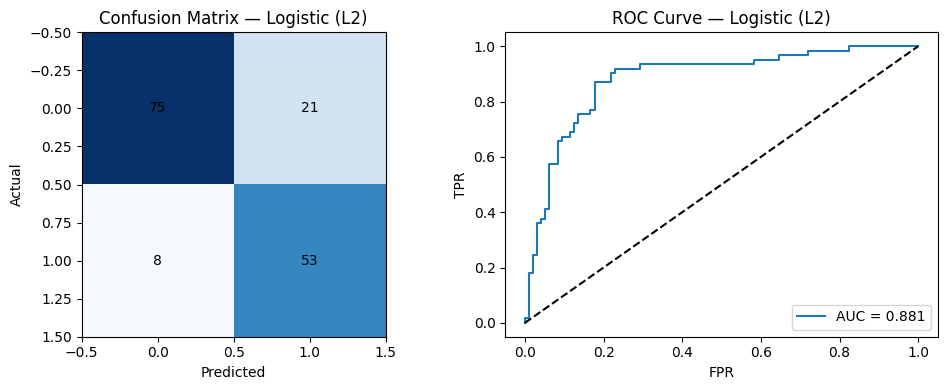

In [60]:
# Logistic L2
log_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000).fit(Xc_tr_sc, yc_tr)
yp_l2 = log_l2.predict(Xc_te_sc); ypb_l2 = log_l2.predict_proba(Xc_te_sc)[:,1]
eval_clf(yc_te, yp_l2, ypb_l2, "Logistic (L2)")

The logistic regression model with L2 regularization achieves a performance practically identical to that obtained with L1 regularization, reaching an accuracy of 82% and an AUC of 0.88.

This indicates an excellent ability to distinguish between earthquakes that generate tsunamis and those that do not. The confusion matrix shows a small number of errors, with few false positives and negatives, demonstrating a robust and balanced behavior of the classifier.

The complete overlap between the L1 and L2 results suggests that the relevant predictor variables are well-defined and that the model is stable, regardless of the type of penalty applied.

### 7.3 Classification using Random Forest

In this section, a Random Forest model is applied to classify earthquakes based on their probability of generating a tsunami.

RandomForest -> Acc:0.898 Prec:0.869 Rec:0.869 F1:0.869 AUC:0.942


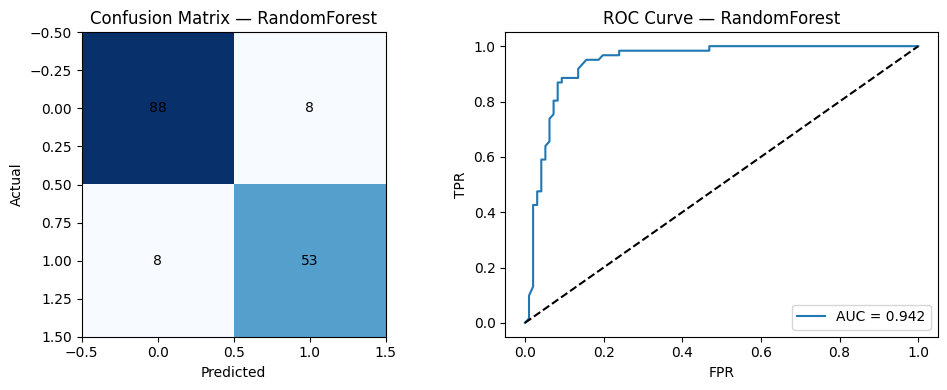

In [61]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42).fit(Xc_tr, yc_tr)
yp_rf = rf.predict(Xc_te); ypb_rf = rf.predict_proba(Xc_te)[:,1]
eval_clf(yc_te, yp_rf, ypb_rf, "RandomForest")

The Random Forest model achieves the best performance so far, reaching an accuracy of 90% and an AUC of 0.94, reflecting an excellent classification capability.

The confusion matrix shows a very small number of errors: only 8 false positives and 8 false negatives, indicating that the model distinguishes with high precision between events with a tsunami and those that do not cause one. 

The ROC curve shows an almost perfect separation from the random diagonal, with a very steep initial slope and TPR values close to 1 even at low false positive rates.

Compared to the logistic regression models (L1 and L2), Random Forest shows a clear improvement in all metrics (precision, recall, F1, and AUC), demonstrating a greater capacity to capture non-linear and complex relationships between variables. This suggests that tsunami behavior may depend on more subtle interactions that linear models fail to represent fully.

### 7.4 Classification using XGBoost

In this section, the XGBoost (Extreme Gradient Boosting) model is used to classify earthquakes based on their probability of generating tsunamis.

XGBoost -> Acc:0.904 Prec:0.871 Rec:0.885 F1:0.878 AUC:0.939


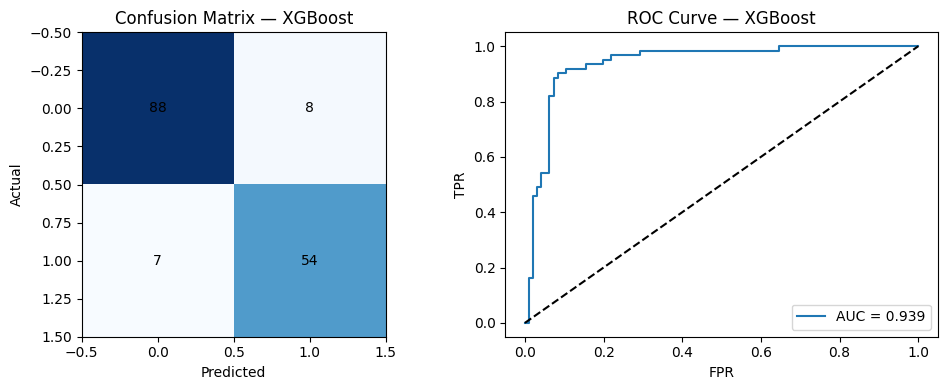

In [62]:
# XGBoost
xgb = XGBClassifier(n_estimators=400, max_depth=4, subsample=0.9, colsample_bytree=0.9, learning_rate=0.05, random_state=42, n_jobs=1)
xgb.fit(Xc_tr, yc_tr)
yp_x = xgb.predict(Xc_te); ypb_x = xgb.predict_proba(Xc_te)[:,1]
eval_clf(yc_te, yp_x, ypb_x, "XGBoost")

The XGBoost model achieves excellent performance, with 90.4% accuracy and an AUC of 0.939, matching the performance of Random Forest but with a slight improvement in recall and precision.

The confusion matrix shows a very small number of errors: only 8 false positives and 7 false negatives, indicating an excellent ability to correctly detect tsunami events without compromising negative cases.

The ROC curve shows a very sharp separation from the random line, confirming the model's high discrimination capability.

Compared to previous results, XGBoost offers the best overall balance, combining the precision of Random Forest with a very slight efficiency in error correction. This suggests that the boosting approach highly effectively captures the complex patterns present in seismic data.

Overall, the applied models demonstrate a high capacity for predicting tsunami occurrences based on seismic characteristics. While Logistic Regression (L1 and L2) offers solid and easily interpretable results, tree-based methods like Random Forest and XGBoost stand out for their higher precision and ability to capture non-linear relationships.

Depending on the objective of the analysis, one might choose different models: if the goal is maximum predictive performance, tree algorithms are the best choice; however, if interpretability and explaining the results are prioritized, Logistic Regression is more suitable.

## 8. Conclusions and Notes

### 1. What characteristics differentiate earthquakes that produce tsunamis from those that do not?

Primarily, location and the measurement context. Events that generate tsunamis tend to occur in areas further away from recording stations, with fewer stations tracking them, and at lower latitudes. In other words, in this dataset, location factors and instrumental coverage carry more weight than the "strength" of the earthquake itself.

### 2. Are the strength or shallowness of earthquakes related to tsunami generation?

With the available data, we can state that they are not. Neither magnitude nor depth has shown clear differences between earthquakes with and without a tsunami. This does not mean that they do not have an influence in reality, but rather that this dataset does not contain sufficient signal (it lacks key physical variables, such as fault type, distance to the coast, bathymetry, etc.).

### 3. Are there natural patterns or distinct groups of earthquakes based on their seismic and geographical characteristics?

Yes. When grouping the data without labels, groups emerge that are explained primarily by geographical location and how they are covered by the seismic network. It is not just that earthquakes can be organized by magnitude or depth, but also by where they occur and how they are measured.

### 4. To what extent do seismic characteristics allow for predicting the magnitude of an earthquake?

In this case, it cannot be predicted. The regression model obtained approximately R² ≈ 0.17, which means that the variables in the catalog explain very little of the magnitude. To be able to predict it even minimally, we would likely need more specific data on the seismic process (fault mechanism, rupture parameters, distance to the coast, properties of the medium, etc.).

### 5. Is it possible to predict whether an earthquake will generate a tsunami based on its seismic and geographical characteristics?

Yes, it is possible, as this dataset achieves relatively good accuracy. The models reached an AUC of approximately 0.94, indicating very strong predictive capability when combining all available variables. In other words, while a single variable tells us very little, the complete set allows for high-precision prediction within this dataset.

### Dataset Feedback

Although at first glance the dataset size did not seem sufficient to answer the target questions of this project, it ultimately yielded relatively good results.

Overall, the dataset is useful but imbalanced. It allows for the identification of clear patterns and predicts with fairly high precision whether an earthquake will end up generating a tsunami when all variables are combined, indicating that it contains relevant information for that purpose. However, its explanatory and predictive capacity is much more limited regarding magnitude, where the available variables provide very little signal. This suggests that the catalog accurately captures where events occur and how they are recorded, but does not include enough physical information about the seismic process itself to estimate its real size. In other words, the dataset is suitable for studying geographical and instrumental patterns and for classifying tsunami occurrence, but it is insufficient for modeling and predicting magnitude without incorporating more detailed geodynamic and rupture data.